# **CMI: Behavior Detection Model 1D-CNN 🌌🧠** 

This is my full solution for the Child Mind Institute "Detect Behavior with Sensor Data" Kaggle competition, [which is linked here](https://www.kaggle.com/competitions/cmi-detect-behavior-with-sensor-data)

***

**✎  Overview:**

Have you ever wondered what makes someone tick? How about, what *is* a tick? This interesting problem from the Child Mind Institute asks us to investigate Body-Focused Repetitive Behaviors (BFRBs) such as nail-biting, hair-pulling and skin-picking, in an effort to better understand how they relate to Obsessive Compulsive Disorder (OCD). 

In a month-long research study conducted by the institute, 81 subjects were given a wrist device (developed by CMI, called "Helios") to wear for an extended period of time. While wearing the device, they were instructed to perform 18 different gestures from 1-4 sitting positions including sitting, sitting while leaning forward with their non-dominant arm resting on their leg, lying on their back, and lying on their side. [Gesture example video](https://youtu.be/WJVFUSJm4As?si=2XfSJGNk4j3Lja4D)


**✎  Data and Task:**

Among these gestures, there were 8 gestures classified as "BRFB-like", and 10 gestures classified as "non-BFRB-like", where BFRB-like gestures being linked to OCD.

With this competition, the Child Mind Institute has tasked the Kaggle-verse with building a predictive machine learning model that correctly identifies and labels sequences of observations as one of these 18 gestures. This time series data, recorded with the Helios device, is made up of sequences with 50-700 observations each, with observations being recorded at 10 Hz.

The Helios device recorded 3D acceleration data (in x/y/z directions), orientation data (with w/x/y/z quaternions), temperature, as well as 5 sets of "time-of-flight" data (we'll explore this in greater detail later). The acceleration and orientation components are a cateogry of observation commonly referred to as Inertial Measurement Units (IMU), and I will refer to them this way throughout this notebook. If you'd like to read more about the specific sensors used in this study, you can do so here:

- [Accelerometer](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/IMU_Sensor.pdf)
- [Temperature](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Thermopile_Sensor.pdf)
- [Time-of-Flight](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Time_of_Flight_Sensor.pdf)


**✎  Gestures:**

*BFRB:*
Above ear - Pull hair, Forehead - Pull hairline, Forehead - Scratch, Eyebrow - Pull hair, Eyelash - Pull hair, Neck - Pinch skin, Neck - Scratch, Cheek - Pinch skin

*non-BFRB:*
Drink from bottle/cup, Glasses on/off, Pull air toward your face, Pinch knee/leg skin, Scratch knee/leg skin, Write name on leg, Text on phone, Feel around in tray and pull out an object, Write name in air, Wave hello


## ✨ Let's begin! ✨

In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from matplotlib.ticker import PercentFormatter
from matplotlib.cm import viridis
from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial.transform import Rotation as R

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

A custom color palette for tables **(may not work in all formats) ✨**

In [2]:
# custom yellow-orange-bronze color palette
def apply_gold_standard_style(styler):
    styler.background_gradient(cmap='YlOrBr', low=0, high=1, subset=num_cols)
    styler.format('{:.2f}', subset=num_cols)
    styler.set_properties(subset=cat_cols, **{'color': 'black', 'background-color': 'white'})
    styler.set_properties(**{'text-align': 'center', 'font-size': '12px', 'border': '1px solid white'})
    styler.set_table_styles([{'selector': 'th', 'props': [('background-color', '#ffd700'),
        ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('font-size', '14px'),
        ('border', '1px solid white')]}])
    return styler

In [3]:
# load train data
train_placeholder = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")
train = train_placeholder.copy()

print(f"Train shape: {train.shape}")
num_cols = train.select_dtypes(include='number').columns
cat_cols = train.select_dtypes(exclude='number').columns
display(train.head().style.pipe(apply_gold_standard_style))

Train shape: (574945, 341)


### Time-of-Flight Data:

Here we can see that the darkness of the yellow corresponds to the relative size of the values within each column, and gives a visual indicator for how the data is changing between observations. Scrolling to the right will reveal just how many "TOF" columns there are in this dataset, 320 in total. 

These 320 columns are split into 5 groups of 64, each of which could be thought of as an 8x8 grid of pixels, with each observation corresponding to a pixel. The value of each observation measures the perpendicular distance between that pixel on the surface of the wrist-device and the nearest physical surface/object/person, ranging on a relative sale for non-missing values from 0-254. So essentially, this data creates 5 depth-maps, giving robust information of the subject's physical surroundings.

![TOF diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F26856272%2F4efb2102b438d83fb3a65e135acaa14b%2FHelios_ToF_Grid_Fig.jpg?generation=1747669734957727&alt=media)

In addition to the sensor data, we also see some categorical indicator columns. Most of these just have to do with maintaining the structure of the dataset and will not be used in training, but some are interesting to investigate further. For example, the "phase" column separates each sequence into "transition" (transitioning into the gesture) and "gesture" (actually performing the gesture), and the "behavior" column further separates each sequence into "relaxes and moves hand to target location", "hand at target location", and "performs gesture".

In [4]:
# load train demographics data
train_demo = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")

print(f"Train Demographics shape: {train_demo.shape}")
num_cols = train_demo.select_dtypes(include='number').columns
cat_cols = train_demo.select_dtypes(exclude='number').columns
display(train_demo.head().style.pipe(apply_gold_standard_style))

Train Demographics shape: (81, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1.00,41.00,1.00,1.00,172.00,50.00,25.00
1,SUBJ_001430,0.00,11.00,0.00,1.00,167.00,51.00,27.00
2,SUBJ_002923,1.00,28.00,1.00,0.00,164.00,54.00,26.00
3,SUBJ_003328,1.00,33.00,1.00,1.00,171.00,52.00,25.00
4,SUBJ_004117,0.00,15.00,0.00,1.00,184.00,54.00,28.00


We've also been provided a separate demographics dataset that records some basic etrics about each subject in the study.

Most of this is not that important (since we aren't training on it), but notice the "handedness" column - here "1" means right-handed and "0" means left-handed. Which arm the subject is wearing the device on completely flips our data, so this is important to take note of.

In [5]:
# load test data
test = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv")

print(f"Test shape: {test.shape}")
num_cols = test.select_dtypes(include='number').columns
cat_cols = test.select_dtypes(exclude='number').columns
display(test.head().style.pipe(apply_gold_standard_style))

Test shape: (107, 336)


This the test dataset, made up of only two sequences, each from different subjects, and each containing about 40-60 observations.

While this dataset is an indicator for what we should expect to be evaluating on, **it is not the true test set**. The true test set is hidden from competition participants and is fed into our notebook for evaluation in sequences through an API. That said, the true test set will also have only two sequences.

In [6]:
# load test demographics data
test_demo = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv")

print(f"Test Demographics shape: {test_demo.shape}")
num_cols = test_demo.select_dtypes(include='number').columns
cat_cols = test_demo.select_dtypes(exclude='number').columns
display(test_demo.head().style.pipe(apply_gold_standard_style))

Test Demographics shape: (2, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_016452,1.00,25.00,1.00,1.00,165.00,52.00,23.00
1,SUBJ_055840,0.00,13.00,0.00,1.00,177.00,52.00,27.00


And these are the corresponding demographics for the test set (we probably won't need this)

## Some Unique Challenges for this Problem

Given the sequenced time-series format, sheer volume of features and complexity of the problem at hand, there are a number of unique challenges for this problem.

### Righties vs. Lefties
As briefly mentioned, a small handful of participants are left-handed and therefore wore the Helios device on their left hand instead of their right. Since the test set does not indicate whether a subject is left-handed or right-handed, those specific subjects will have to be indentified using the demographics data, and then all of the IMU data for the sequences corresponding to those subjects will need to be transformed in order to align with the rest of the right-handed subjects.

### Gravity
Gravity permeates all IMU data in this problem and can muddy our observations, so we will have to acknowledge it and take it into account when engineering out features.

### Bad Sequences
The sequences in this dataset vary immensely in length, with some having about 20 observations and some having almost 700 - our model may struggle to adapt to new sequences with such varied behavior. There is no perfect solution, but a precaution we can take is to simply drop sequences that fall below a certain length (say, 15 observations). Since the true test set will only contain 2 sequences, we can be fairly confident that a sequence that short will not appear in the true test set.

### Varied Sequence Length
Following from the note about sequences varying in length, since our model cannot take in sequences of different sizes, we will have to *pad* all sequences to have the same size. To account for the largest sequences, this means filling sequences with a varying amounts of noise so that all sequences have an equal length (700 observations). Thankfuly, the model should be able to pick up pretty quick that this extra noise is just noise and should not be trained on.

### Subjects #019262 and #045235
These two bozos decided to wear the wrist devices on their heads for the whole study (yes, seriously). This fact was observed in the first-place solution for this problem, [which you can check out here](https://www.kaggle.com/competitions/cmi-detect-behavior-with-sensor-data/writeups/cmi-1st-place-solution). This data is likely not salvageable so I will remove those two subjects from the data entirely.

In [7]:
# remove subjects 019262 and 045235 from train and test datasets
train = train[train['subject'] != 'SUBJ_019262']
train = train[train['subject'] != 'SUBJ_045235']
test = test[test['subject'] != 'SUBJ_019262']
test = test[test['subject'] != 'SUBJ_045235']

In [8]:
# drop duplicate rows (if they exist)
print(f"Rows Missing Target Variable: {train['gesture'].isna().sum()}")
train.drop_duplicates(inplace=True)

Rows Missing Target Variable: 0


## Example of a full IMU sequence
Below is an example of a full IMU sequence for a "Cheek - pinch skin" gesture, containing 51 observations. The shading indicates the relative largeness of the figure within its associated column.

In [9]:
# display example of an IMU sequence
seq_027987 = train[train['sequence_id'] == 'SEQ_027987'].copy()
seq_027987 = seq_027987.drop(["sequence_id", "subject", "orientation", "behavior"], axis=1)
seq_027987 = seq_027987.drop(seq_027987.loc[:, "thm_1" : "tof_5_v63"].columns, axis=1)
num_cols = seq_027987.select_dtypes(include='number').columns
cat_cols = seq_027987.select_dtypes(exclude='number').columns
display(seq_027987.head(52).style.pipe(apply_gold_standard_style))

,row_id,sequence_type,sequence_counter,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z
247361,SEQ_027987_000000,Target,0.00,Transition,Cheek - pinch skin,6.09,-0.10,-9.16,0.32,-0.43,-0.83,-0.15
247362,SEQ_027987_000001,Target,1.00,Transition,Cheek - pinch skin,5.05,0.24,-9.62,0.23,-0.50,-0.81,-0.20
247363,SEQ_027987_000002,Target,2.00,Transition,Cheek - pinch skin,5.78,1.81,-7.21,0.12,-0.64,-0.67,-0.36
247364,SEQ_027987_000003,Target,3.00,Transition,Cheek - pinch skin,6.35,2.73,-4.18,0.03,-0.73,-0.46,-0.51
247365,SEQ_027987_000004,Target,4.00,Transition,Cheek - pinch skin,8.99,1.89,-3.04,0.03,0.77,0.25,0.58
247366,SEQ_027987_000005,Target,5.00,Transition,Cheek - pinch skin,10.18,1.20,-1.39,0.07,0.78,0.08,0.62
247367,SEQ_027987_000006,Target,6.00,Transition,Cheek - pinch skin,9.27,1.36,-1.08,0.10,0.76,0.03,0.64
247368,SEQ_027987_000007,Target,7.00,Transition,Cheek - pinch skin,10.22,1.66,-1.16,0.10,0.75,0.03,0.65
247369,SEQ_027987_000008,Target,8.00,Transition,Cheek - pinch skin,9.65,1.62,-1.50,0.10,0.76,0.03,0.65
247370,SEQ_027987_000009,Target,9.00,Transition,Cheek - pinch skin,9.57,1.62,-1.39,0.10,0.76,0.03,0.65


## EDA 🎨

Here are some simple charts for viewing the demographic data.

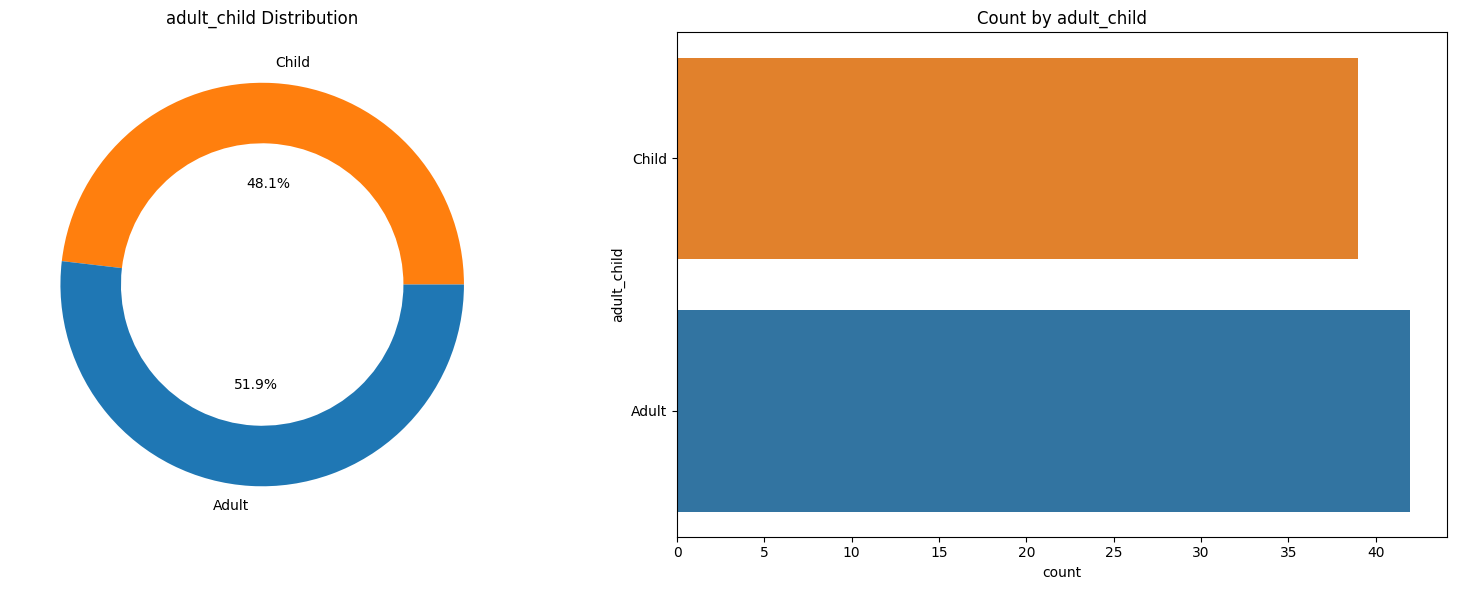

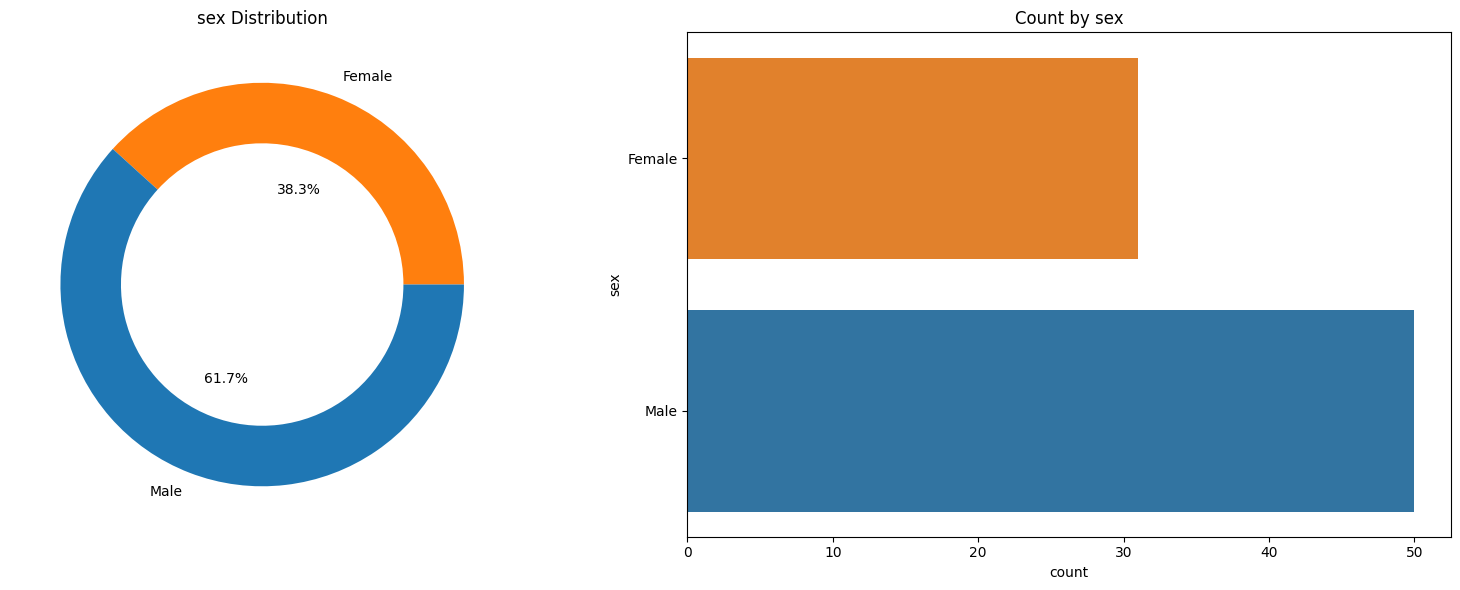

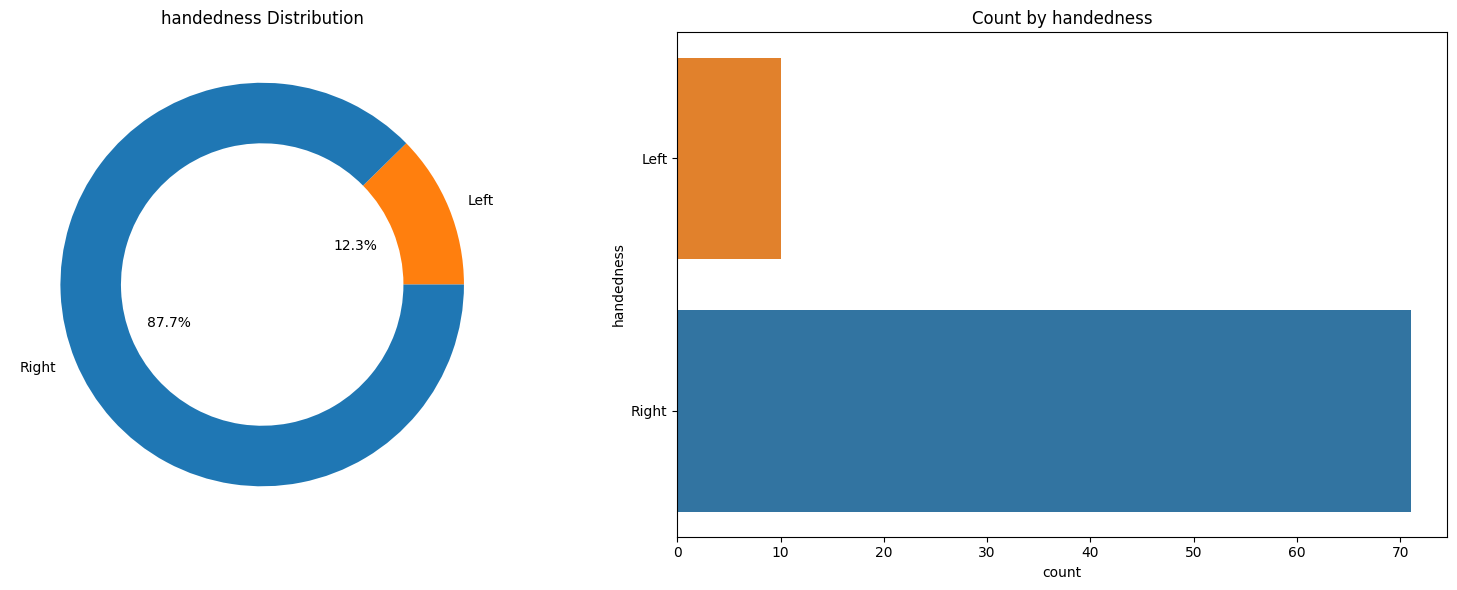

In [10]:
# categorical variables to analyze with respective value mappings
categorical_variables = ["adult_child", "sex", "handedness"]
value_mappings = {"adult_child": {0: "Child", 1: "Adult"}, "sex": {0: "Female", 1: "Male"}, "handedness": {0: "Left", 1: "Right"}}

# define plotting function for categorical variables
def plot_categorical(variable, data, value_mapping=None):

    colors = {0: '#ff7f0e', 1: '#1f77b4'}
    plt.figure(figsize=(16, 6))
    
    # get value counts and sort by index
    value_counts = data[variable].value_counts().sort_index()
    
    # create labels using the mapping if available, otherwise use original values
    labels = [value_mapping.get(i, str(i)) for i in value_counts.index]
    
    # pie chart
    plt.subplot(1, 2, 1)
    plt.pie(value_counts, autopct='%1.1f%%', colors=[colors.get(i, '#2ca02c') for i in value_counts.index], wedgeprops=dict(width=0.3), labels=labels, pctdistance=0.5)
    plt.title(f"{variable} Distribution")
    
    # countplot
    plt.subplot(1, 2, 2)
    ax = sns.countplot(data=data, y=variable, order=value_counts.index, palette=[colors.get(i, '#2ca02c') for i in value_counts.index])
    
    # update y-tick labels
    ax.set_yticklabels(labels)
    plt.title(f"Count by {variable}")
    plt.tight_layout()
    plt.show()

# generate plots for each categorical variable
for var in categorical_variables:
    if var in train_demo.columns:
        plot_categorical(variable=var, data=train_demo, value_mapping=value_mappings.get(var))

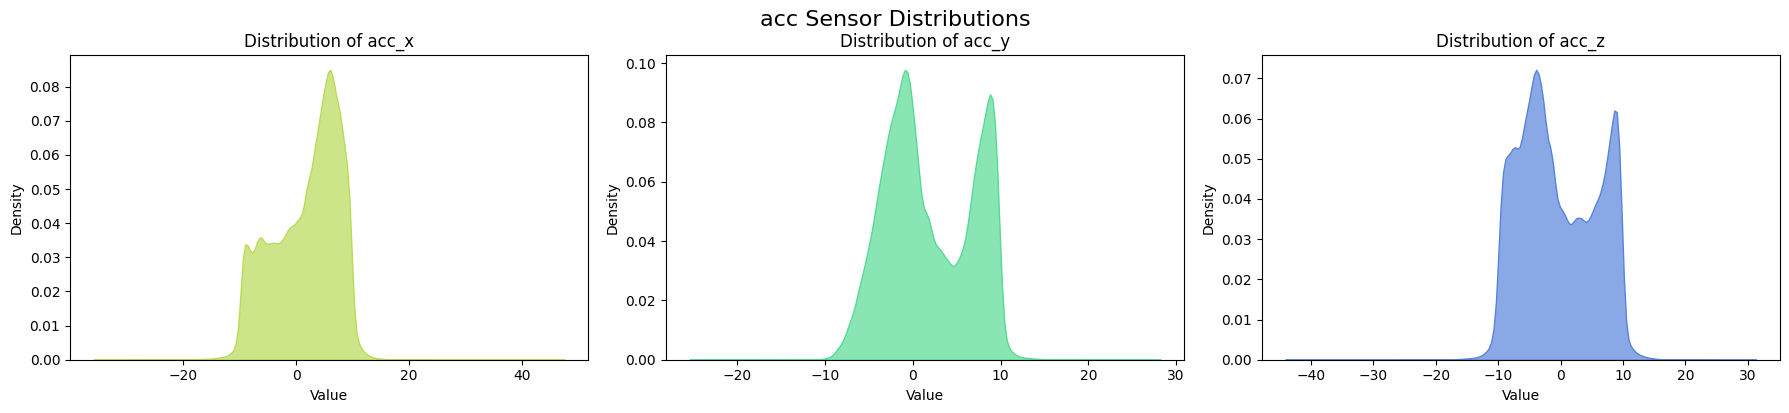



Summary Statistics for acc sensors:


,count,mean,std,min,25%,50%,75%,max
acc_x,562688.0,1.722759,5.752787,-34.585938,-2.765625,3.074219,6.371094,46.328125
acc_y,562688.0,1.874918,4.978619,-24.402344,-2.074219,0.753906,6.906250,27.183594
acc_z,562688.0,-0.454414,6.096569,-42.855469,-5.421875,-1.562500,5.179688,30.078125


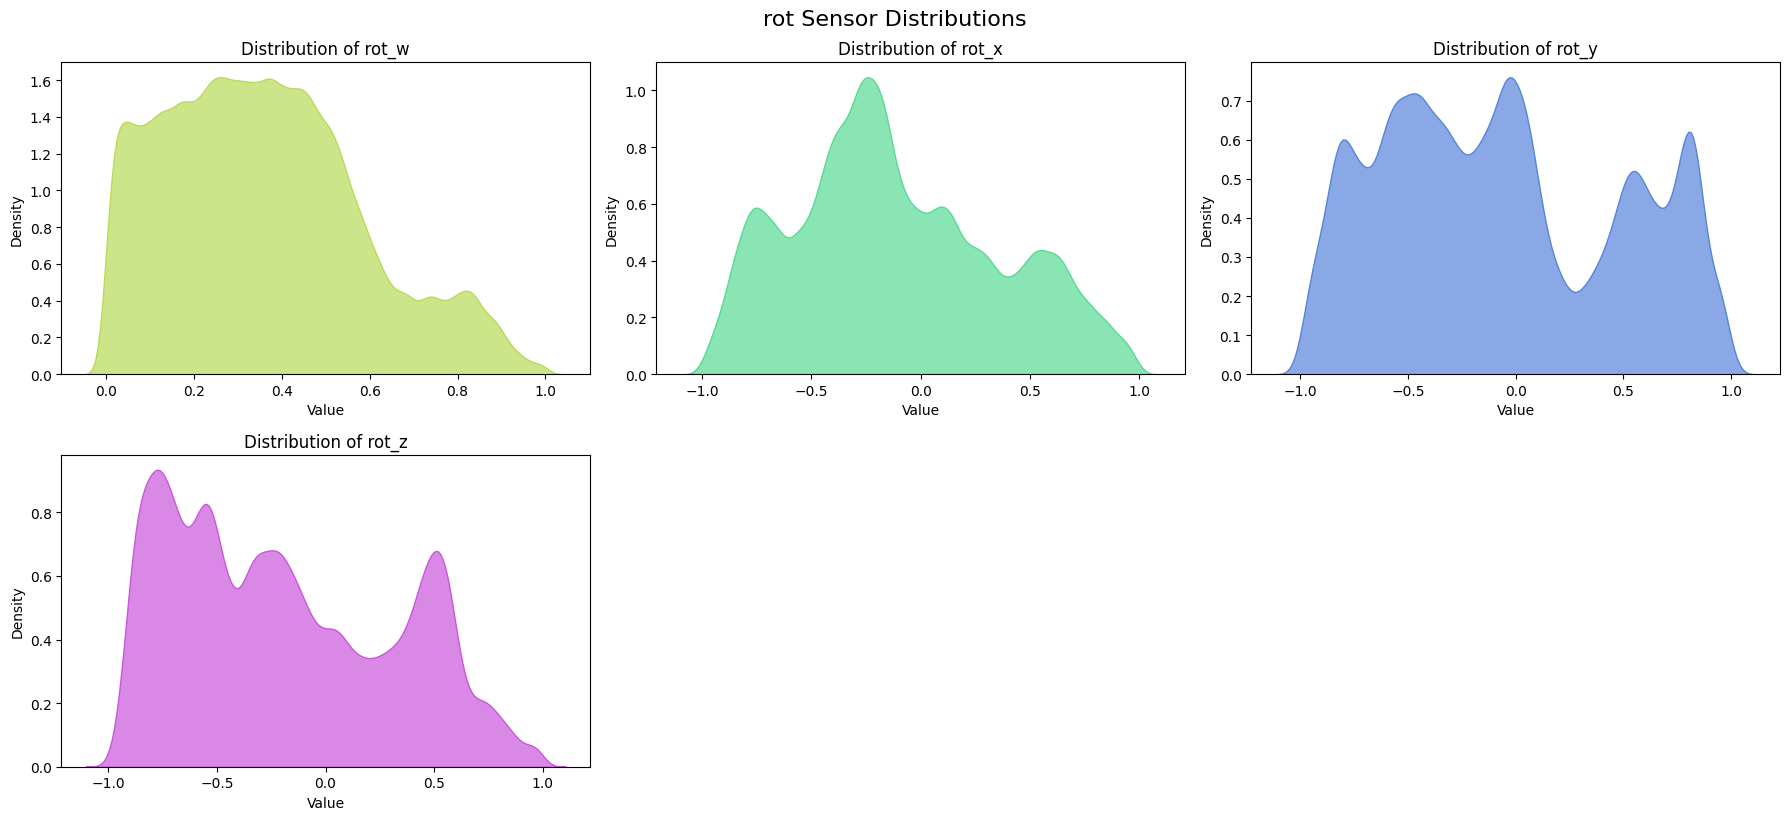



Summary Statistics for rot sensors:


,count,mean,std,min,25%,50%,75%,max
rot_w,558996.0,0.357413,0.224144,0.000000,0.178406,0.337769,0.499939,0.999390
rot_x,558996.0,-0.113529,0.465845,-0.999146,-0.447388,-0.181763,0.214539,0.999817
rot_y,558996.0,-0.066103,0.543077,-0.999695,-0.514893,-0.122070,0.435547,0.999451
rot_z,558996.0,-0.194103,0.505111,-0.998169,-0.635437,-0.272949,0.245178,0.999878


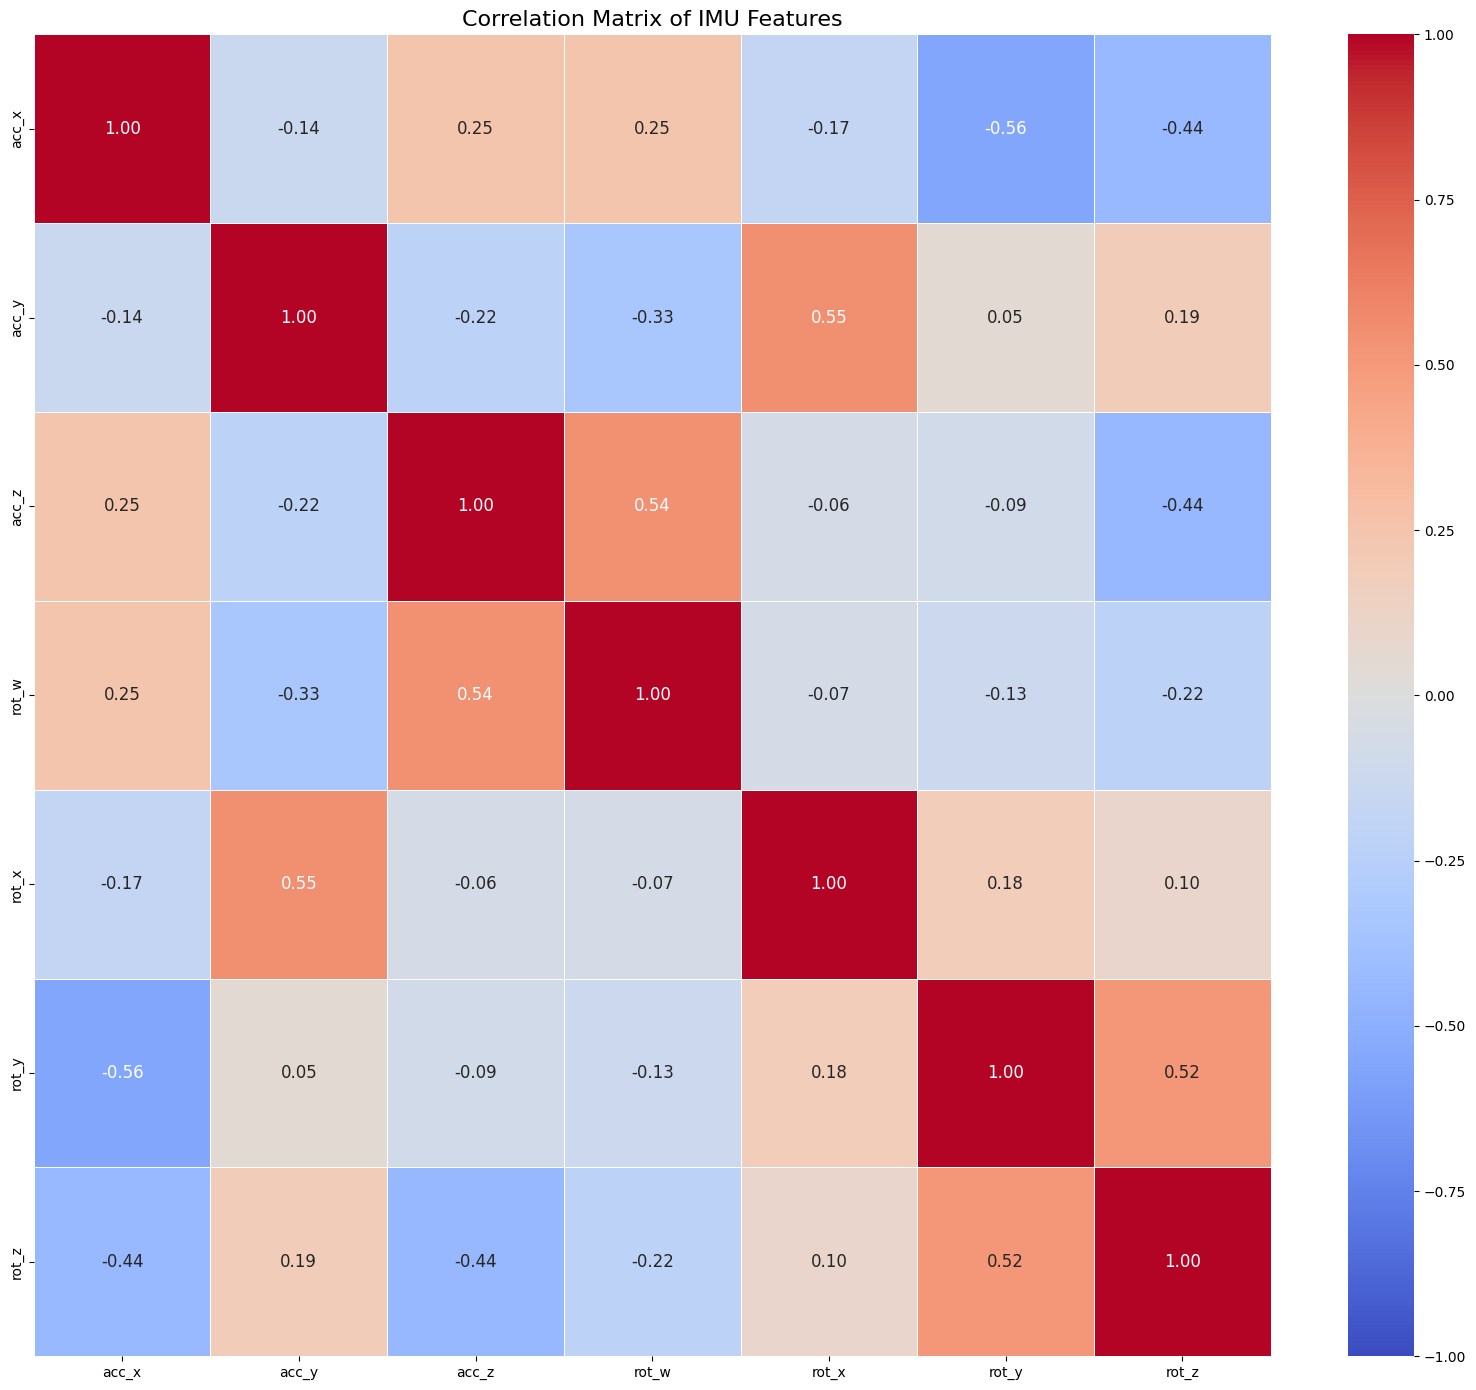

In [11]:
custom_palette = sns.color_palette("hls", n_colors=5)

# plotting density curve function
def plot_sensor_distributions(df, sensor_type, cols_per_row=3):
    sensor_cols = [col for col in df.columns if sensor_type in col]
    n_cols = len(sensor_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    plt.figure(figsize=(18, 4 * n_rows))
    for i, col in enumerate(sensor_cols, 1):
        plt.subplot(n_rows, cols_per_row, i)
        sns.kdeplot(df[col].dropna(), fill=True, alpha=0.7, 
                    color=custom_palette[i % len(custom_palette)])
        plt.title(f'Distribution of {col}', fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Density')
    plt.tight_layout()
    plt.suptitle(f'{sensor_type} Sensor Distributions', y=1.02, fontsize=16)
    plt.show()
    print()
    print(f"\nSummary Statistics for {sensor_type} sensors:")
    display(df[sensor_cols].describe().T)
    print()
    print()

# visualize IMU distributions
plot_sensor_distributions(train, 'acc')
plot_sensor_distributions(train, 'rot')

# generate correlation heatmap
sensor_cols = [col for col in train.columns if 'acc' in col or 'rot' in col]
if sensor_cols:
    plt.figure(figsize=(16, 14))
    corr_matrix = train[sensor_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"fontsize": 12})
    plt.title('Correlation Matrix of IMU Features', fontsize=16)
    plt.tight_layout()
    plt.show()

Looking at correlations we can see the natural relationship between acceleration and orientation data (notice right above the bottom-left/top-right diagonal - every correlation has a magnitude over 0.5).

### Data Missingness

Here's a visual displaying the proportion of missing values per feature. You'll notice the overwhelming majority of missing values come from the TOF columns, and further that "missingness" appears to either increase or decrease within each depth-map. It's quite a cool thing to look at.

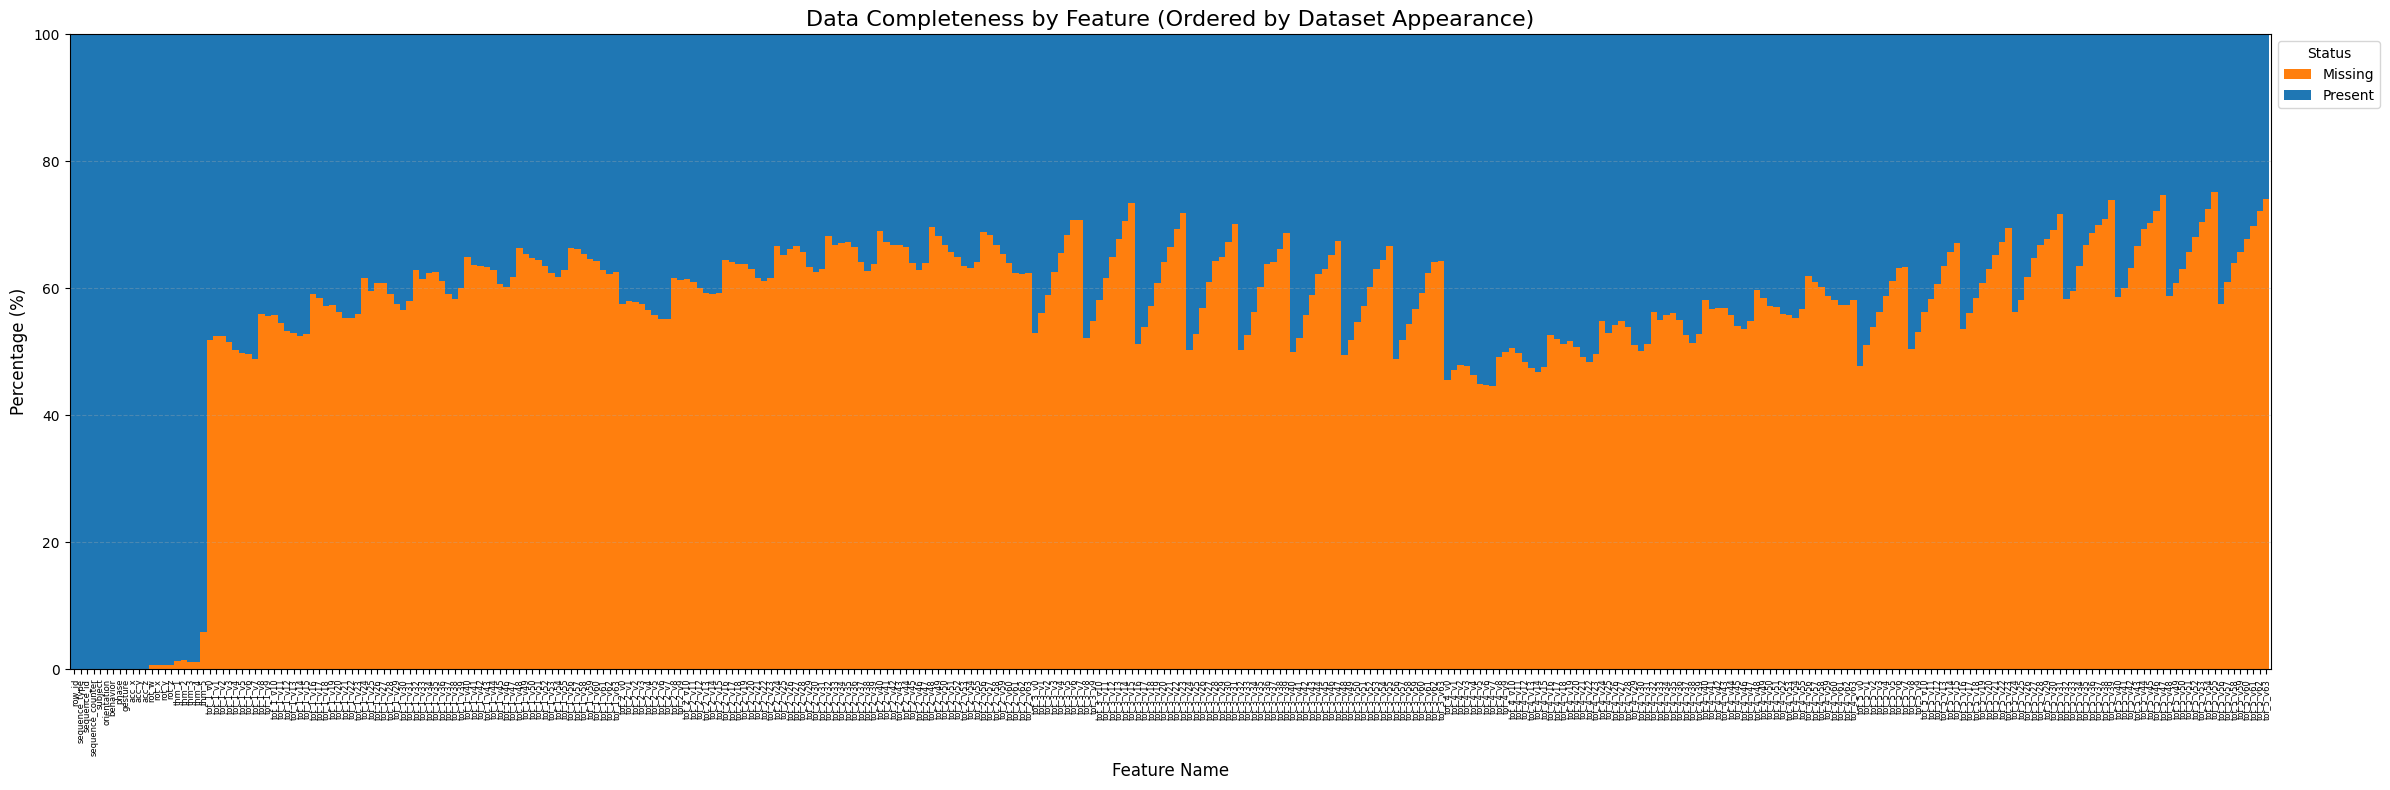

In [12]:
# replace -1 and 0 with NaN in Time-of-Flight columns
tof_cols = [c for c in train.columns if c.startswith('tof_')]
train[tof_cols] = train[tof_cols].replace([-1, 0], np.nan)
test[tof_cols] = test[tof_cols].replace([-1, 0], np.nan)

# calculate missingness
missing_pct = train.isnull().mean() * 100
completeness_df = pd.DataFrame({'Missing': missing_pct,'Present': 100 - missing_pct})

# generate stacked bar chart
plt.figure(figsize=(24, 8)) 
ax = completeness_df.plot(kind='bar', stacked=True, color=['#ff7f0e', '#1f77b4'], width=1.0, ax=plt.gca())
plt.title('Data Completeness by Feature (Ordered by Dataset Appearance)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Feature Name', fontsize=12)
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Status')
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

So much missingess in these columns poses another potential issue for the model - it will have to learn how to intelligently work around so much useless data, as we are essentially feeding it the whole sequence while wanting it to learn only from the blue area.

Since the TOF data is measuring distance from a given pixel to the nearest object, an intelligent way to impute this missing data would be fill with a large number like 400. This is basically saying "there is nothing anywhere near this pixel". Because this gives the model as little information as possible, it will learn to ignore it. 

If we left missing values as 0, the model *might* learn to ignore these values due to sheer number of them, but since 0 also means "there is something pressed up against this pixel", the model might get overwhelmed and take these values seriously, which would blow the whole thing up.

In [13]:
from sklearn.impute import SimpleImputer

# impute missing rot values with 0
rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
train[rots] = train[rots].fillna(0)

# fill missing temperature data with average by column
thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
imputer = SimpleImputer(strategy='constant', fill_value=0)
train[thms] = imputer.fit_transform(train[thms])

# fill all NaNs in time-of-flight (ToF) columns with 400
tof_train = train.loc[:, "tof_1_v0" : "tof_5_v63"].columns
train[tof_train] = train[tof_train].fillna(400)
tof_test = test.loc[:, "tof_1_v0" : "tof_5_v63"].columns
test[tof_test] = test[tof_test].fillna(400)

### A Closer Examination of Gestures

Here is a look at how the gestures are distributed throughout the data. You will notice that some are much more common than others.

Recall that "target" indicates a gesture is BFRB-like and "non-target" indicates it is non-BFRB-like.

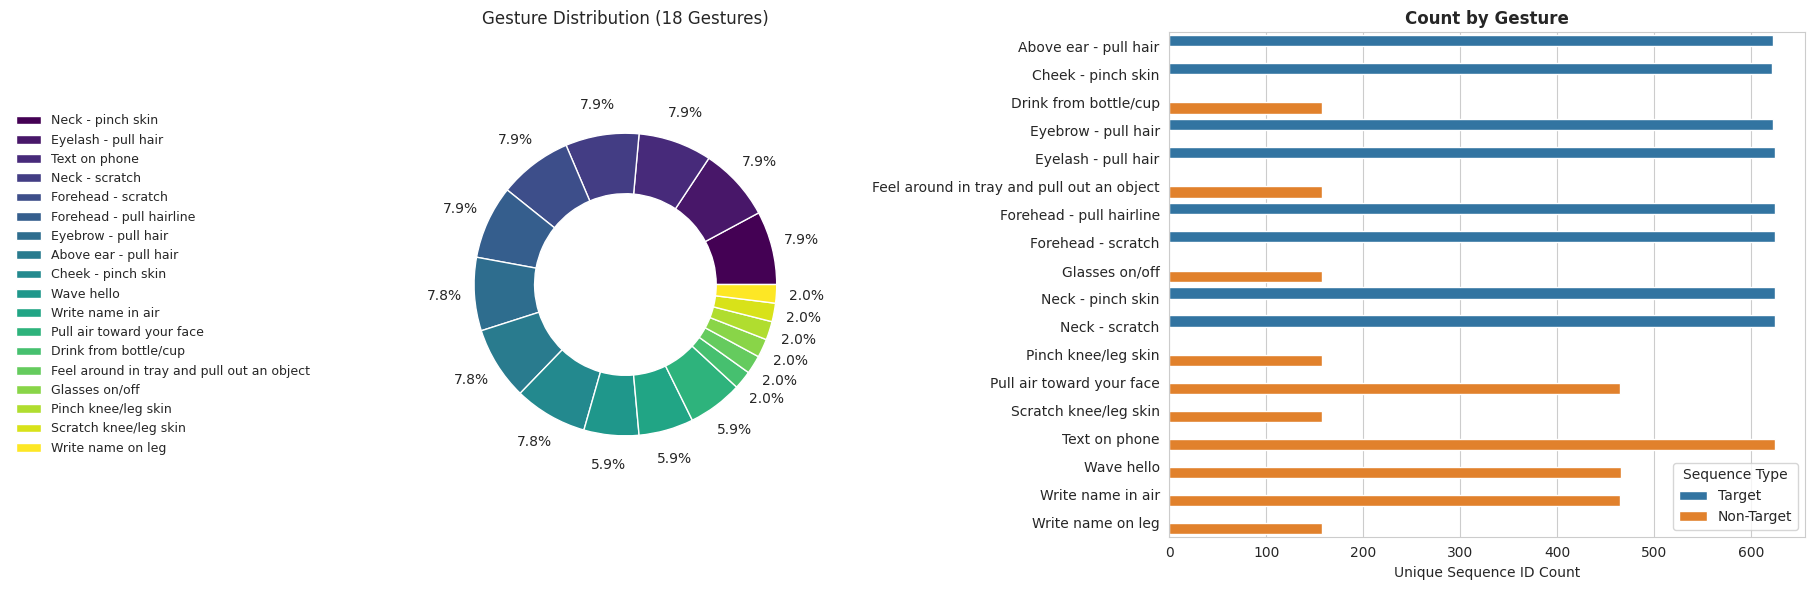

In [14]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# gesture distribution donut chart
value_counts = train.groupby('gesture')['sequence_id'].nunique().sort_values(ascending=False)
num_gestures = len(value_counts)
palette = [to_hex(viridis(i / (num_gestures - 1))) for i in range(num_gestures)]
ax1.pie(value_counts, autopct='%1.1f%%', colors=palette, radius=0.75, wedgeprops={'width': 0.3}, pctdistance=1.2)
ax1.legend(value_counts.index, bbox_to_anchor=(-0.1, 0.5), loc='center right', prop={'size': 9}, frameon=False, borderpad=0.5, labelspacing=0.5)
ax1.set_title(f"Gesture Distribution ({num_gestures} Gestures)")
group_df = train.groupby(['gesture', 'sequence_type'])['sequence_id'].nunique().reset_index()

# generate bar count plot
sns.barplot(data=group_df, y='gesture', x='sequence_id', hue='sequence_type', palette=['#1f77b4', '#ff7f0e'], ax=ax2)
ax2.set(xlabel='Unique Sequence ID Count', ylabel='')
ax2.legend(title='Sequence Type')
ax2.set_title("Count by Gesture", fontweight='bold')

plt.tight_layout()
plt.show()

I also thought it would be interesting to visualize the gestures themselves, as a way of understanding what kind of patterns the model will be learning from. Here is a selection of gestures from subject #023739 showing the acceleraion magnitude and rotation angle over the course of the sequence.

Rotation angle here can be thought of as "the total deviation from home", "home" being some resting place.

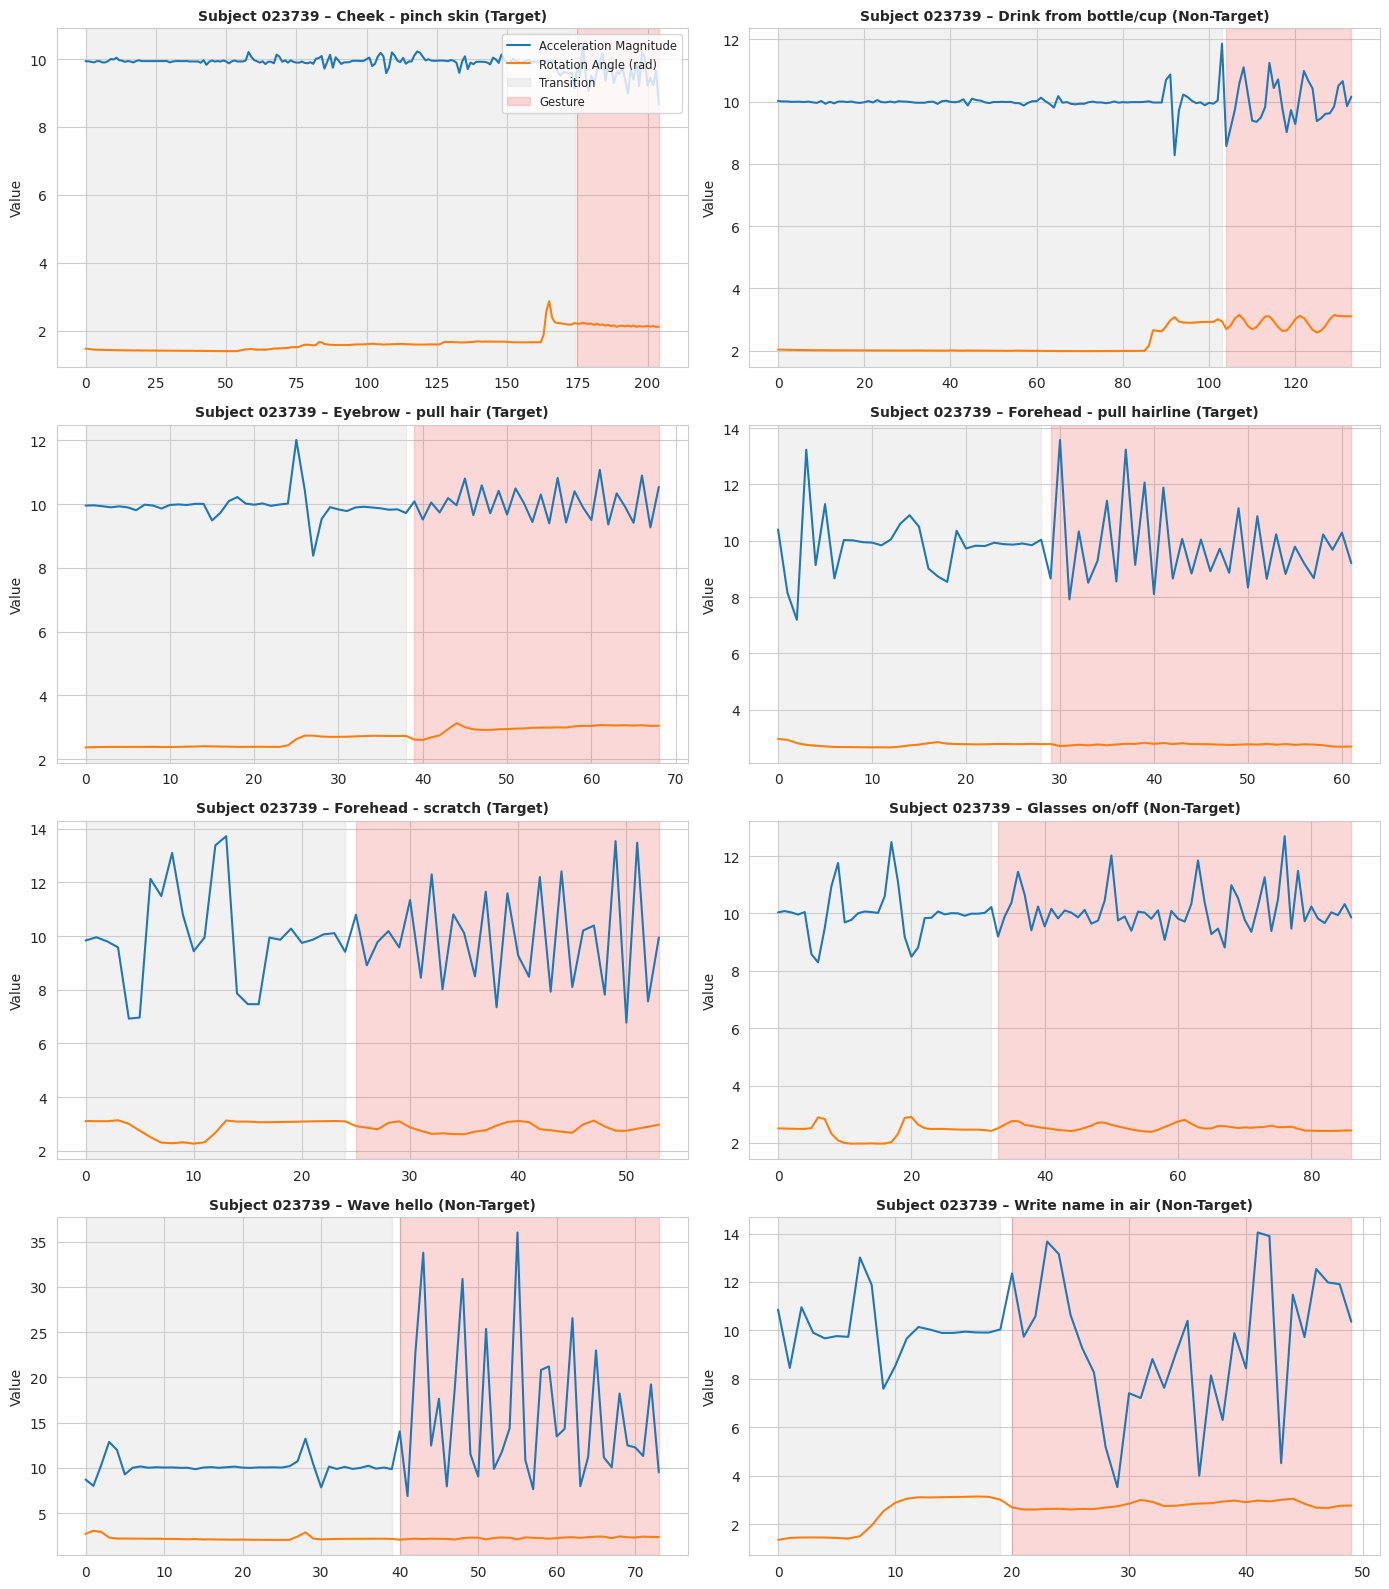

In [15]:
# GESTURE SAMPLE ANALYSIS FROM SUBJECT 023739

# compute features
subj_023739 = train[train['subject'] == 'SUBJ_023739'].copy()
subj_023739['acc_mag'] = np.sqrt(subj_023739[['acc_x', 'acc_y', 'acc_z']].pow(2).sum(axis=1))
subj_023739['rot_angle'] = 2 * np.arccos(subj_023739['rot_w'].clip(-1, 1))

# get one sequence per gesture
selected_gestures = ["Cheek - pinch skin", "Drink from bottle/cup", "Eyebrow - pull hair", "Forehead - pull hairline", "Forehead - scratch", "Glasses on/off", "Wave hello", "Write name in air"]
seq_ids = subj_023739[subj_023739['gesture'].isin(selected_gestures)].groupby('gesture')['sequence_id'].first().values

# setup figure
n = len(seq_ids)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), squeeze=False)
axes = axes.flatten()

# plot data
for i, seq in enumerate(seq_ids):
    ax = axes[i]
    df = subj_023739[subj_023739['sequence_id'] == seq].sort_values('sequence_counter')
    times = df['sequence_counter']
    ax.plot(times, df['acc_mag'], label='Acceleration Magnitude', color='tab:blue')
    ax.plot(times, df['rot_angle'], label='Rotation Angle (rad)', color='tab:orange')
    
    # add phase shading
    for phase, color in [('Transition', 'lightgray'), ('Gesture', 'lightcoral')]:
        mask = df['phase'] == phase
        idxs = np.where(mask)[0]
        for start, end in zip(np.concatenate(([0], np.where(np.diff(idxs) > 1)[0] + 1)), np.concatenate((np.where(np.diff(idxs) > 1)[0], [len(idxs)-1]))):
            t0, t1 = df.iloc[idxs[start]]['sequence_counter'], df.iloc[idxs[end]]['sequence_counter']
            ax.axvspan(t0, t1, color=color, alpha=0.3, label=phase if phase not in ax.get_legend_handles_labels()[1] else None)
    
    # format subplot
    ax.set_title(f"Subject 023739 – {df['gesture'].iloc[0]} ({df['sequence_type'].iloc[0]})", fontsize=10, fontweight='bold')
    ax.set(xlabel="", ylabel="Value")
    ax.legend(loc='upper right', fontsize='small').set_visible(i == 0)
    ax.grid(True)

# clean up and show
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

It's fun to look at these graphs and try to follow the acceleration curve while doing the gesture yourself. This is relatively easy to do for most of them (like "drink from bottle/cup" or "wave hello"), but in others can be a bit more difficult to conceptualize ("write name in air"). We can see from these graphs that not all gestures are cleanly performed and some seem to have unusual spikes/detours, like the big spike that occurs between observations 20-30 in "eyebrow - pull hair". Did that subject have a spasm before they began performing the gesture?

We are beginning to see that our model has a lot to figure out, because not all gestures follow an obvious, easily recognizeable path. It will have to learn to look past things like the big spike in the eyebrow - pull hair gesture and say "yes, I see this jolt at the start of the sequence, but I still think that this is eyebrow - pull hair". Thankfully, neural networks are quite good at this.

Just for fun, and this might be overkill, but I wanted to take a closer look at one of the more clearly trackable gestures, "wave hello", so I created a 3D rendering of acceleration for this particular gesture for subject #052342.

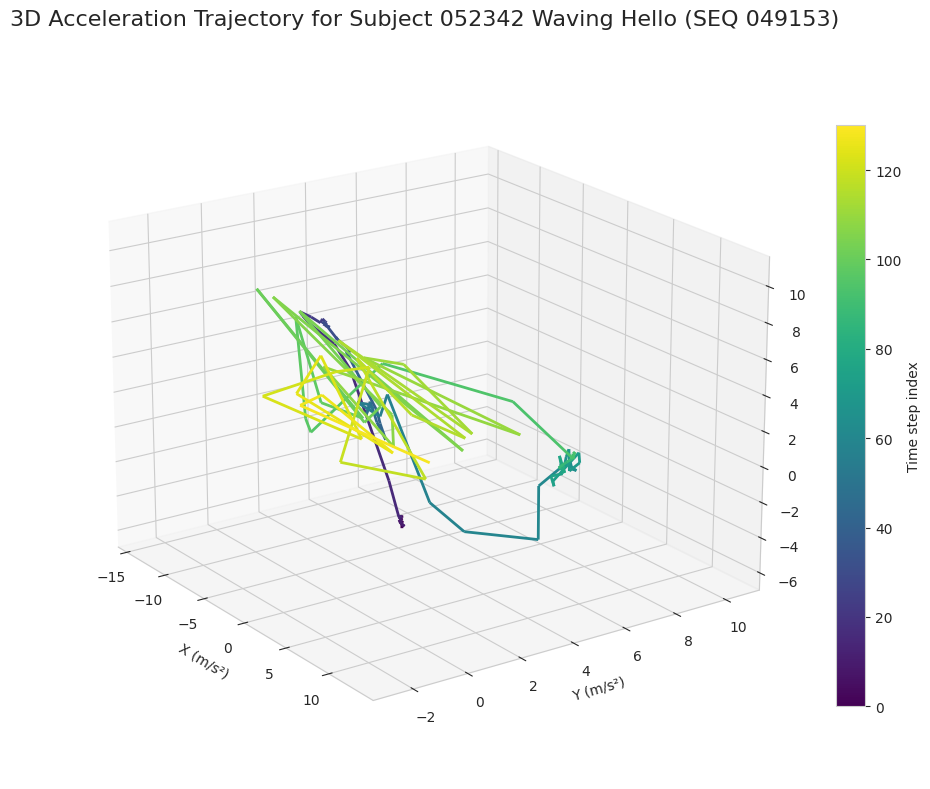

In [16]:
# 3D RENDERING OF ACCELERATION TRAJECTORY FOR SUBJECT 052342 WAVING "HELLO"

seq_049153 = train[train['sequence_id'] == 'SEQ_049153'].copy()
x_data = seq_049153['acc_x'].values
y_data = seq_049153['acc_y'].values
z_data = seq_049153['acc_z'].values

# plot 3D trajectory
def plot_3d_trajectory(x, y, z, title="3D Trajectory"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    time_steps = np.arange(len(x))
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = plt.get_cmap('viridis')
    lc = Line3DCollection(segments, cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    lc.set_array(time_steps)
    lc.set_linewidth(2)
    ax.add_collection3d(lc)

    # add a color bar
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.set_label('Time step index')

    # customize the plot
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X (m/s²)')
    ax.set_ylabel('Y (m/s²)')
    ax.set_zlabel('')

    # final details
    buffer = 1.5
    ax.set_xlim(x.min() - buffer, x.max() + buffer)
    ax.set_ylim(y.min() - buffer, y.max() + buffer)
    ax.set_zlim(z.min() - buffer, z.max() + buffer)
    ax.view_init(elev=20., azim=-35)
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_3d_trajectory(x_data, y_data, z_data, title="3D Acceleration Trajectory for Subject 052342 Waving Hello (SEQ 049153)")

It's nice that this particular sequence has very little transition time because it makes the gesture so clearly visible. The subject brings their hand up in the first 40 observations, swoops it around swoops it around for the next 40, and then waves back-and-forth (albeit a little haphazardly) for the rest of the sequence. 

### Bad Sequences

In [17]:
# filter out short gesture sequences (bad data)
print("Before filtering:", train.shape)
gesture_counts = ((train['phase'] == 'Gesture').groupby(train['sequence_id']).transform('sum'))
train = train[gesture_counts >= 15].reset_index(drop=True)
print("After filtering:",train.shape)

Before filtering: (562688, 341)
After filtering: (560044, 341)


Filtering out 2,644 bad sequences where each sequence contains 15 observations or less means that we have removed *at least* 176 sequences from our dataset that might potentially confuse the model.

### Taking account for the Lefties

Looking through the demographics dataset we can identify the following subjects as being left-handed:

- 002923
- 013623
- 019756
- 028998
- 032233
- 032585
- 039234
- 041243
- 055211
- 061552

Since gestures are recorded in various positions, it is impossible to be completely precise about how a left-handed action would be converted to a right-handed frame. A good generalization is to rotate the acceleration data by 180 degrees (clean conversion from left-right) and rotate the orientation data by about 90 degrees - *why?*

Imagine you are wearing a watch and sitting with both of your hands resting on a table. Is the watch facing directly up towards the ceiling? Probably not - that would be unnatural and uncomfortable. It's probably resting about 45 degrees between facing the ceiling and being perpendicular to the table. So, switching the watch from hand to the other would be a 90 degree rotation. We're not assuming that all sequences are recorded with subjects sitting at a table, but considering we have to account for 4 different positions, this is a fine enough middle ground solution.

What about non-IMU data, like the Time-of-Flight sensors? While it is true that they would record different information if on different hands, without any information on what the subjects' surroundings *are* we have no way interpolating that data from what we currently have. So, we'll leave that as is, even if it's technically wrong - and besides, we're probably starting to get too in the weeds here.

In [18]:
# STANDARDIZE LEFT HAND TO MATCH RIGHT HAND

lefties = ["SUBJ_002923", "SUBJ_013623", "SUBJ_019756", "SUBJ_028998", "SUBJ_032233", "SUBJ_032585", "SUBJ_039234", "SUBJ_041243", "SUBJ_055211", "SUBJ_061552"]
lefty_mask = train.subject.isin(lefties)

# transform acceleration data
train.loc[lefty_mask, 'acc_y'] = -train.loc[lefty_mask, 'acc_y']
train.loc[lefty_mask, 'acc_z'] = -train.loc[lefty_mask, 'acc_z']

# transform orientation data
q_original = train.loc[lefty_mask, ['rot_w', 'rot_x', 'rot_y', 'rot_z']].copy()
train.loc[lefty_mask, 'rot_w'] = -q_original['rot_x']
train.loc[lefty_mask, 'rot_x'] =  q_original['rot_w']
train.loc[lefty_mask, 'rot_y'] = -q_original['rot_z']
train.loc[lefty_mask, 'rot_z'] =  q_original['rot_y']

## Feature Engineering



In [19]:
import random

# create validation set
sequences = train['sequence_id'].unique().tolist()
val_sequences = random.sample(sequences, int(len(sequences) * 0.2))
validation = train[train['sequence_id'].isin(val_sequences)].copy()
train = train[~train['sequence_id'].isin(val_sequences)].reset_index(drop=True)

In [20]:
# define irrelevant columns
columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']

# remove irrelevant columns from train, test and validation sets (leaving backup validation for evaluation)
train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
validation = validation.drop(columns=[col for col in columns_to_drop if col in validation.columns])
test = test.drop(columns=[col for col in columns_to_drop if col in test.columns])

# create set list
sets = [train, test, validation]

Deciding on what features to create is a tricky and cautious process - but for this problem, creating features from the IMU features will be most valuable, as pointed out earlier, many of the IMU features are inter-correlated with one another.

The five temperature sensors measure a singular piece of data, temperature, which doesn't really have any obvious relationships with other features in the data - for instance, I don't think a feature like "change in temperature over acceleration magnitude" would give the model much information to work with.

The TOF data on the other hand is so mind-bogglingly complex that I think for me, any way to try and engineer something clever from those 320 columns would end in disaster. Maybe it could be done, but at my skill level, I wouldn't even know where to begin. So I will leave it as is.

### Features to Engineer:

- **linear acceleration features (acceleration without gravity):** lin_acc_x, lin_acc_y, lin_acc_z

We remove gravity by defining a gravity vector [0, 0, 9.81], rotating it based on the orientation of the device, and then subtracting the gravity vector from acclereation component-wise. Instead of simply deleting the acceleration after doing this, I will opt to keep both and let the model do what it wants with them.

- **acceleration magnitude features (for regular and linear acceleration:** acc_mag, lin_acc_mag

This is simply the square root of the sum of the squares of the individual acceleration features - we calculated this previously when visualizing the gestures, but we'll re-define it here.

- **magnitude jerk features (derivative of acceleration):** acc_mag_jerk, lin_acc_mag_jerk

Jerk is simply the derivative of acceleration. We could theoretically calculate jerk for all acceleration columns, but I think this would be overkill. We'll stick with the two acceleration magnitude columns.

- **rotation agnle:** rot_angle

This can be thought of as the distance from where the wrist-device is centered - we also defined this previously.

- **angular distance:** angular_distance

Angular distance measures the relative magnitude of change in the rotation data between two timesteps. It can be thought of as a derivative, similar to jerk for the acceleration data.

- **angular velocity:** angular_vel_x, angular_vel_y, angular_vel_z

Angular velocity measures the speed that the device is spinning along a given axis. This splits this metric into 3 features, one for each axis.

- **rotation angle velocity:** rot_angle_vel

This metric measures the speed at which the wrist device is spinning in any given direction, at any given observation.

In [21]:
# de-fragment train/test/val sets
train = train.copy()
test = test.copy()
validation = validation.copy()

In [22]:
# consolidated calculation of features
def calculate_sequence_features(group):
    acc = group[['acc_x', 'acc_y', 'acc_z']].values
    rot = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    time_step = 0.1
    gravity_world = np.array([0, 0, 9.81])
    new_feats = {}

    # -> SIMPLE FEATURES
    # linear acceleration (acceleration w/ gravity removed)
    norms = np.linalg.norm(rot, axis=1)
    valid_mask = norms > 1e-6
    lin_acc = acc.copy()
    
    if np.any(valid_mask):
        q_norm = rot[valid_mask] / norms[valid_mask][:, None]
        r = R.from_quat(q_norm)
        g_sensor = r.apply(gravity_world, inverse=False)
        lin_acc[valid_mask] = acc[valid_mask] - g_sensor

    new_feats['lin_acc_x'] = lin_acc[:, 0]
    new_feats['lin_acc_y'] = lin_acc[:, 1]
    new_feats['lin_acc_z'] = lin_acc[:, 2]

    # magnitudes of acceleration
    acc_mag = np.linalg.norm(acc, axis=1)
    lin_acc_mag = np.linalg.norm(lin_acc, axis=1)
    new_feats['acc_mag'] = acc_mag
    new_feats['lin_acc_mag'] = lin_acc_mag

    # jerk features (derivatives [gradient] of magnitudes)
    new_feats['acc_mag_jerk'] = np.gradient(acc_mag, time_step)
    new_feats['lin_acc_mag_jerk'] = np.gradient(lin_acc_mag, time_step)

    # rotation angle
    rot_w_clipped = np.clip(group['rot_w'].values, -1.0, 1.0)
    new_feats['rot_angle'] = 2 * np.arccos(rot_w_clipped)

    # -> COMPLEX FEATURES
    q_curr = rot
    q_prev = np.roll(rot, 1, axis=0)
    q_prev[0] = [0, 0, 0, 1]
    q_prev_conj = q_prev.copy()
    q_prev_conj[:, :3] = -q_prev_conj[:, :3]
    w1, x1, y1, z1 = q_curr[:, 3], q_curr[:, 0], q_curr[:, 1], q_curr[:, 2]
    w2, x2, y2, z2 = q_prev_conj[:, 3], q_prev_conj[:, 0], q_prev_conj[:, 1], q_prev_conj[:, 2]
    delta_w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    
    # angular Distance
    delta_w_clip = np.clip(delta_w, -1.0, 1.0)
    ang_dist = 2 * np.arccos(delta_w_clip)
    ang_dist[0] = 0
    new_feats['angular_distance'] = ang_dist
    
    # rotation angle velocity
    new_feats['rot_angle_vel'] = ang_dist / 0.1

    # angular velocity
    delta_x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    delta_y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    delta_z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    
    # normalize delta
    delta_vec = np.stack([delta_x, delta_y, delta_z], axis=1)
    dnorm = np.linalg.norm(delta_vec, axis=1)
    angle_full = 2.0 * np.arctan2(dnorm, delta_w)
    with np.errstate(divide='ignore', invalid='ignore'):
        scale = angle_full / (time_step * dnorm)
        scale[dnorm < 1e-12] = 2.0 / time_step
    omega = delta_vec * scale[:, None]
    omega[0] = [0, 0, 0]
    new_feats['angular_vel_x'] = omega[:, 0]
    new_feats['angular_vel_y'] = omega[:, 1]
    new_feats['angular_vel_z'] = omega[:, 2]
    return pd.DataFrame(new_feats, index=group.index)

# consolidate and add new features to train/test/val datasets
names = ['train', 'test', 'validation']
NEW_IMU_FEATURES = ['lin_acc_x', 'lin_acc_y', 'lin_acc_z','acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']

for i, dataset in enumerate(sets):
    dataset = dataset.copy()
    results = [calculate_sequence_features(group) for _, group in dataset.groupby('sequence_id')]
    all_new_features = pd.concat(results)
    dataset = pd.concat([dataset, all_new_features], axis=1)
    id_cols = ['sequence_id']
    
    if 'gesture' in dataset.columns:
        id_cols.append('gesture')
    original_cols = [col for col in dataset.columns if col not in id_cols and col not in NEW_IMU_FEATURES]
    final_order = id_cols + NEW_IMU_FEATURES + original_cols
    dataset = dataset[final_order]
    
    if names[i] == 'train':
        train = dataset
    elif names[i] == 'test':
        test = dataset
    elif names[i] == 'validation':
        validation = dataset

### Feature Scaling

Here I will use a RobustScaler to scale the data down to a smaller, more workable range. A RobustScaler is great becuase it uses the inter-quartile range to define its max and min, and then scales all exceeding values down to that max and min - this will minimize the negative effect of sudden glitches or spikes *(like the one we observed in the "eyebrow - pull hair" gesture from subject #023739 earlier).*

In [23]:
from sklearn.preprocessing import RobustScaler

# fit standard scaler
scaler = RobustScaler() 

# scale train
train_cols_to_exclude = ['sequence_id', 'gesture']
train_cols_to_scale = train.drop(columns=train_cols_to_exclude).columns
scaler.fit(train[train_cols_to_scale])
X_train = scaler.transform(train[train_cols_to_scale])

# scale test
test_cols_to_exclude = ['sequence_id']
test_cols_to_scale = test.drop(columns=test_cols_to_exclude).columns
X_test = scaler.transform(test[test_cols_to_scale])

# scale validation
validation_cols_to_exclude = ['sequence_id', 'gesture']
validation_cols_to_scale = validation.drop(columns=validation_cols_to_exclude).columns
X_val = scaler.transform(validation[validation_cols_to_scale])

In [24]:
# cleaning up variable names (for consistency)
train_IMU_THM_TOF_prescaled = train
train_IMU_THM_TOF_scaled = X_train
test_IMU_THM_TOF_prescaled = test
test_IMU_THM_TOF_scaled = X_test
val_IMU_THM_TOF_prescaled = validation
val_IMU_THM_TOF_scaled = X_val

In [25]:
# garbage collection (for memory)
import gc

del train
del train_placeholder
del X_train
del test
del X_test
del validation
del X_val

***

## Sequencing and Padding

We have to restructure the data to a format that is digestable for the model. This means sequencing (converting to a list of sequences as 2D arrays) and padding the sequences as described before.

In [26]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# monkey patch (screw you "AttributeError" >:( )
import google.protobuf.message_factory
if not hasattr(google.protobuf.message_factory.MessageFactory, 'GetPrototype'):
    def GetPrototype(self, descriptor):
        return self.GetMessageClass(descriptor)
    google.protobuf.message_factory.MessageFactory.GetPrototype = GetPrototype

# importing some more libraries for final pre-processing, model training and warning suppression
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import logging
tf.get_logger().setLevel('ERROR')

E0000 00:00:1764379350.405953      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764379350.466514      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*As of November 2025, there is a bug when initially importing TensorFlow into web-based environments like Kaggle and Google Colab where it attempts to call a method "GetPrototype" that no longer exists. It has no effect on the library's functionality or any code, but it creates a very ugly warning message that takes up nearly half the screen. What you see at the top is a monkey patch that suppresses this warning... I just couldn't bear looking at it!* 🤪

In [27]:
# SEQUENCING: restructuring the data as a list of sequences as 2D arrays
train_IMU_THM_TOF_prescaled = train_IMU_THM_TOF_prescaled.reset_index(drop=True)
test_IMU_THM_TOF_prescaled = test_IMU_THM_TOF_prescaled.reset_index(drop=True)
val_IMU_THM_TOF_prescaled = val_IMU_THM_TOF_prescaled.reset_index(drop=True)

# sequence train data
grouped_train_ALL = train_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_train_ALL = []
labels_train_ALL = []
for sequence_id, group in grouped_train_ALL:
    indices_train = group.index.to_list()
    current_sequence_data = train_IMU_THM_TOF_scaled[indices_train]
    sequences_train_ALL.append(current_sequence_data)
    
    label_train_ALL = group['gesture'].iloc[0]
    labels_train_ALL.append(label_train_ALL)

# sequence test data
grouped_test_ALL = test_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_test_ALL = []
for sequence_id, group in grouped_test_ALL:
    indices_test = group.index.to_list()
    current_sequence_data = test_IMU_THM_TOF_scaled[indices_test]
    sequences_test_ALL.append(current_sequence_data)

# sequence val data
grouped_val_ALL = val_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_val_ALL = []
labels_val_ALL = []
for sequence_id, group in grouped_val_ALL:
    indices_val = group.index.to_list()
    current_sequence_data = val_IMU_THM_TOF_scaled[indices_val]
    sequences_val_ALL.append(current_sequence_data)
    
    label_val_ALL = group['gesture'].iloc[0]
    labels_val_ALL.append(label_val_ALL)

In [28]:
# pad data
def pad_data(sequences, max_length=None):
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', maxlen=700)
    return padded_sequences

train_padded_ALL = pad_data(sequences_train_ALL)
test_padded_ALL = pad_data(sequences_test_ALL)
val_padded_ALL = pad_data(sequences_val_ALL)

y_train_ALL = np.array(labels_train_ALL)
y_val_ALL = np.array(labels_val_ALL)

print("Shape of the final padded data:", train_padded_ALL.shape) 
print("Shape of the final padded data:", test_padded_ALL.shape) 
print("Shape of the final padded data:", val_padded_ALL.shape) 

Shape of the final padded data: (6336, 700, 345)
Shape of the final padded data: (2, 700, 345)
Shape of the final padded data: (1584, 700, 345)


In [29]:
# garbage collection (for memory)
del sequences_train_ALL
del sequences_test_ALL
del sequences_val_ALL
del labels_train_ALL
del labels_val_ALL

To get a sense for what exactly we are feeding into the model at this stage, here is a heatmap showing the relative values for each feature, at each timestep, with values scaled down to the range [0, -1]. 

This gives a slightly different perspective of the "missingness" we first observed during the analysis stage, with yellow "0" values suggesting missingness (although not necessarily implying it). Because most sequences have only about 50-250 observations each, in most cases what we will actually be feeding into our model can be thought of like a blank card or a ticket with a small code on the end for the model to read and interpret, like what you see below.

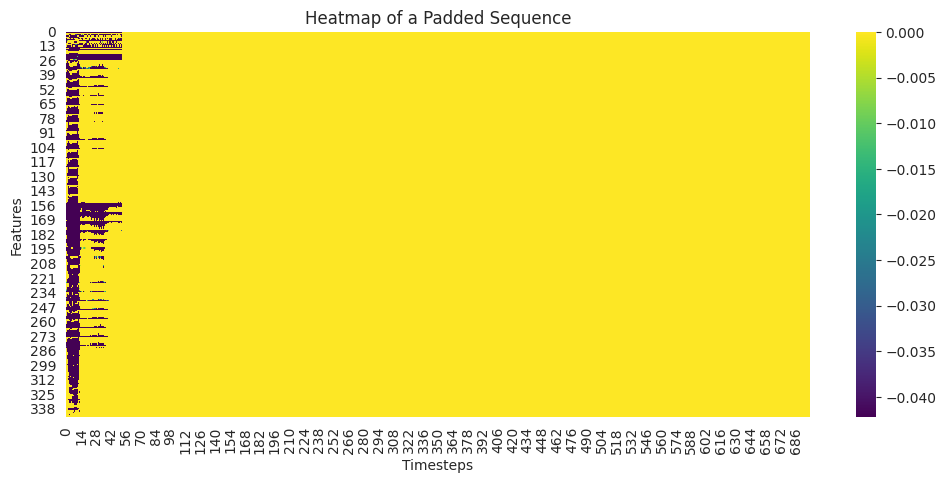

In [30]:
# select a sample to view (the first one)
sample_to_view = train_padded_ALL[1]

# create the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sample_to_view.T, cmap='viridis', robust=True)
plt.title('Heatmap of a Padded Sequence')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()

## Model Training

Now we're getting to the real meat of the project, which is the training stage. When I first got to this stage, I actually walked away from this project for over a month because I was so overwhelmed simply trying to figure out where to begin. Unlike in my last project (which is increasingly looking to me like a toy project), this would require building out a larger training architecture, lots of experimentation, and through that experimentation making iterative improvements to the structure of the model to arrive at something strong that produced an accurate result. 

### Dummy Model

The first step is to define a dummy model to use as a baseline for improvement. This model is about as good as random guessing.

In [31]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# initialize and fit encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ALL)
y_train = label_encoder.transform(y_train_ALL)
y_val = label_encoder.transform(y_val_ALL)

dummy_clf.fit(train_padded_ALL, y_train_ALL)

# predict on the validation set
y_val_pred_dummy = dummy_clf.predict(val_padded_ALL)

# calculate baseline accuracy
baseline_accuracy = accuracy_score(y_val_ALL, y_val_pred_dummy)
print(f"Baseline (Most Frequent) Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline (Most Frequent) Accuracy: 7.20%


The dummy model scores about 7-8%. This means that if out model scores better than that, it will officially be better than randomly guessing! 🎉 Though I think we can do better.

### IMU vs. all data

My initial thought was that I wanted to train two different models, one on only the IMU data and one on the entire dataset, and then ensemble the results. This is pretty common and many other submissions to this competition took this approach. So in a local notebook, I created a copy of the scaled data containing only IMU features (excluding everything past "rot_w"), and then created two separate notebooks with full pre-processing, sequencing and padding pipelines. 

Now, I did not end up ensembling the models in the end - I will explain why I made this decision momentarily But this splitting process did inform my model configuration process, so I think it is important to talk about.

My logic was that it would be easier to experiment with the model on the IMU data, since it's a smaller dataset with slightly less complex inputs, and then once I found a configuration that scored over 50%, I would copy it to my other notebook and adapt it to perform similarly well on that data. 

What ended up happening is that when I brought over the configuration that scored 55% accuracy on the IMU data, it scored even better on the full data! And when I compared the full data and the IMU data results per-gesture, the accuracy was either better or *almost* better for each one. At that point I realized I would get little value from ensembling, and I went ahead with just training on the full dataset.
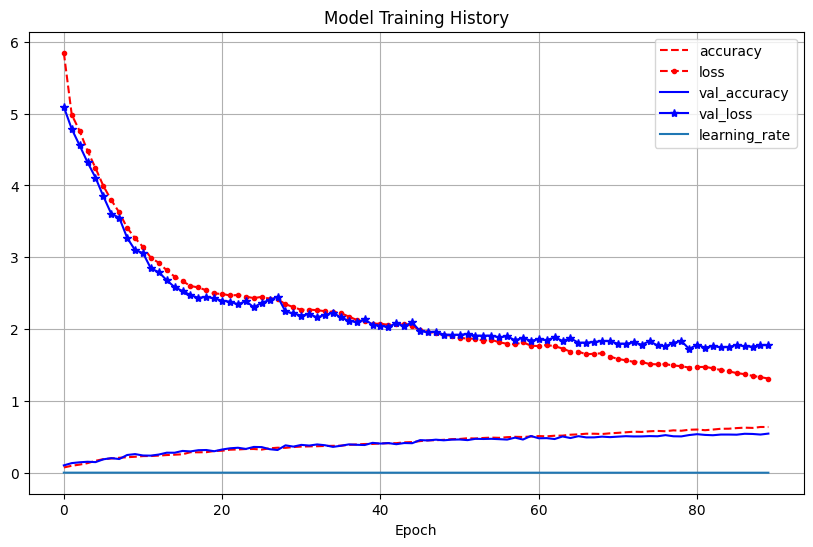

### Model Configuration

And so here begins a documentation of my very interesting experience experimentating with many tools and tricks. There are a *lot* of knobs to play around with and potential combinations seem endless. I am sure the final configuration I got is not the strongest, but as somebody who is new to this field, I'm quite happy with my final model.

***First Iteration:***

The first iteration of the model was simple, containing a masking layer, a single Conv1D layer with 64 filters, relu, a pooling layer using GlobalMaxPooling1D(), and a single dense layer with softmax, and then using a simple Adam optimizer for the compiler.

With this setup I was able to get about 10% val accuracy, only slightly better than guessing. The first thing I did was remove the masking layer, which made a slight improvement - supposedly the neural network is already skilled enough at pattern recognition that it doesn't need to be explicitly told to ignore the padding.

I also experimented a bit with adding LSTM and GRU but got low performance. 

***Second Iteration:***

For the second iteration I defined 5 Conv1D layers, with 128, 128, 256, 256, and 512 filters respectively. I also added a Batch Normalization layer and a Dropout layer after each Conv1D layer, and replaced the single dense layer with 3 dense layers with decreasing filter count. 

This more robust model architecture bumped the total parameter count from 3,358 to 1,988,370 and boosted the val accuracy to the mid 20% range. From playing around with the parameters, it was clear that adding the Batch Normalization and Dropout layers had the biggest effect on this performance boost. 

I played around with tuning dropout further and found that increasing dropout past 0.3-0.5 would cause the model to get stuck at around 10% val accuracy.

***Third Iteration:***

After being stuck for a while I decided to experiment with some different optimizers. I tried AdamW and RMSprop and found AdamW had the best performance, bumping my model up to about 35% val accuracy. My next big leap came from adding an l2 regularizer to each of the Conv1D and Dense layers - this shot my val accuracy up to 48%.

I experimented with l2 regularization strength 0.0001, 0.001, 0.01 and 0.1, and found the model gets the best performance with 0.001, slightly worse performance with 0.1 and 0.01, and significantly worse performance with 0.0001 (almost the same as having no regularozation penalty at all).

Since switching to AdamW gave such a big boost in performance, I also wanted to experiment with some different learning rates. I tried 0.00001, 0.0001, 0.0005, 0.001, and 0.01, and got the best performance with 0.001 and 0.0005, slightly worse with 0.0001, and significantly worse with 0.00001 and 0.01.

It was at this point that I tried this model configuration on the full dataset, and to my delight, got a val accuracy of about 65%.

In [32]:
# set variables
num_timesteps = 700 
num_features = 345
num_classes = 18

# define model
model_ALL = Sequential([
    
    # block 1 
    Input(shape=(num_timesteps, num_features)),
    Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 2 
    Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 3
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 4
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 5
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    
    # dense layers
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# compile model
model_ALL.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ALL.summary()

I0000 00:00:1764379372.345436      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764379372.346005      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 694, 128)       │       309,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 694, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 343, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 343, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 169, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 169, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 82, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 82, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 39, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             

 Total params: 2,286,738 (8.72 MB)

 Trainable params: 2,283,410 (8.71 MB)

 Non-trainable params: 3,328 (13.00 KB)

Throughout this process, I also experimented with some of the model training parameters. For the second iteration, I added a ReduceLROnPlateau callback to lower the learning rate whenever the model's val loss doesn't improve after 10 epochs, which improved overall performance and allowed for easier tuning.

I also experimented with batch sizes 64 and 32, and found slightly better performance with smaller batch sizes.

Labels successfully encoded.
Training model...
Epoch 1/200


I0000 00:00:1764379394.908879     115 service.cc:148] XLA service 0x7db45c110480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764379394.909671     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764379394.909695     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764379395.674046     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/198 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.0208 - loss: 19.4908    

I0000 00:00:1764379404.314862     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.0700 - loss: 7.6933 - val_accuracy: 0.0852 - val_loss: 5.2864 - learning_rate: 0.0010
Epoch 2/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.0927 - loss: 5.2318 - val_accuracy: 0.1338 - val_loss: 4.8506 - learning_rate: 0.0010
Epoch 3/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1263 - loss: 4.8253 - val_accuracy: 0.1452 - val_loss: 4.4978 - learning_rate: 0.0010
Epoch 4/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1346 - loss: 4.4943 - val_accuracy: 0.2001 - val_loss: 4.2489 - learning_rate: 0.0010
Epoch 5/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1596 - loss: 4.2288 - val_accuracy: 0.1938 - val_loss: 3.9618 - learning_rate: 0.0010
Epoch 6/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1835 - loss: 3.9609 - val_accuracy: 0.2708 - val_loss: 3.6648 - learning_rate: 0.0010
Epoch 7/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2244 - loss: 3.6984

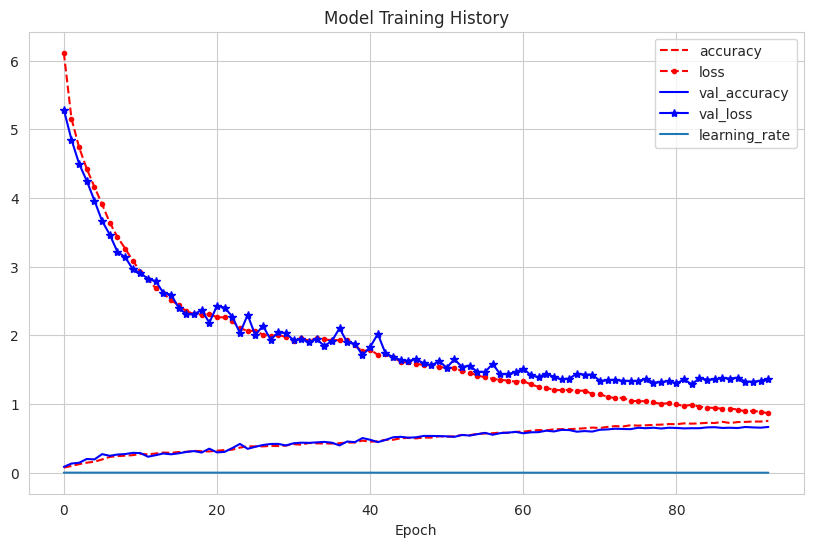

In [33]:
# encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ALL)
y_train_encoded_ALL = label_encoder.transform(y_train_ALL)
y_val_encoded_ALL = label_encoder.transform(y_val_ALL)
print("Labels successfully encoded.")

# define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7, verbose=1)

# train model!!!
print("Training model...")
history_ALL = model_ALL.fit(train_padded_ALL, y_train_encoded_ALL, epochs=200, batch_size=32, validation_data=(val_padded_ALL, y_val_encoded_ALL), callbacks=[early_stopping, reduce_lr])
print("Training complete.")

# plot train/val accuracy/loss
history_ALL_ = pd.DataFrame(history_ALL.history)
history_ALL_.plot(figsize=(10, 6), grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.title("Model Training History")
plt.show()

We can see from the resulting curves a couple of things about our training process. 
The training and validation accuracy increase quickly from epochs 1-10, then both increase at a steady pace until around epoch 60, when the val accuracy starts to trail behind. This means the model starts overfitting near the end of the training process, which causes the final train accuracy score to end up about 10 points higher than the val accuracy.

Something similar happens with loss, only the losses for train and val diverge at around epoch 40. Val loss plateaus suddenly and in a more pronounced way when compared with val accuracy, while train loss continues to decrease at a steady pace.

Because of the way that val loss plateaus, I wondered what would happen if I instead changed the early stopping callback to be conditioned on val accuracy itself, since val accuracy seems to continue increasing (albeit slowly). However when I tried this, the model struggled to make much progress past epoch 90 and the end result was pretty much the same.
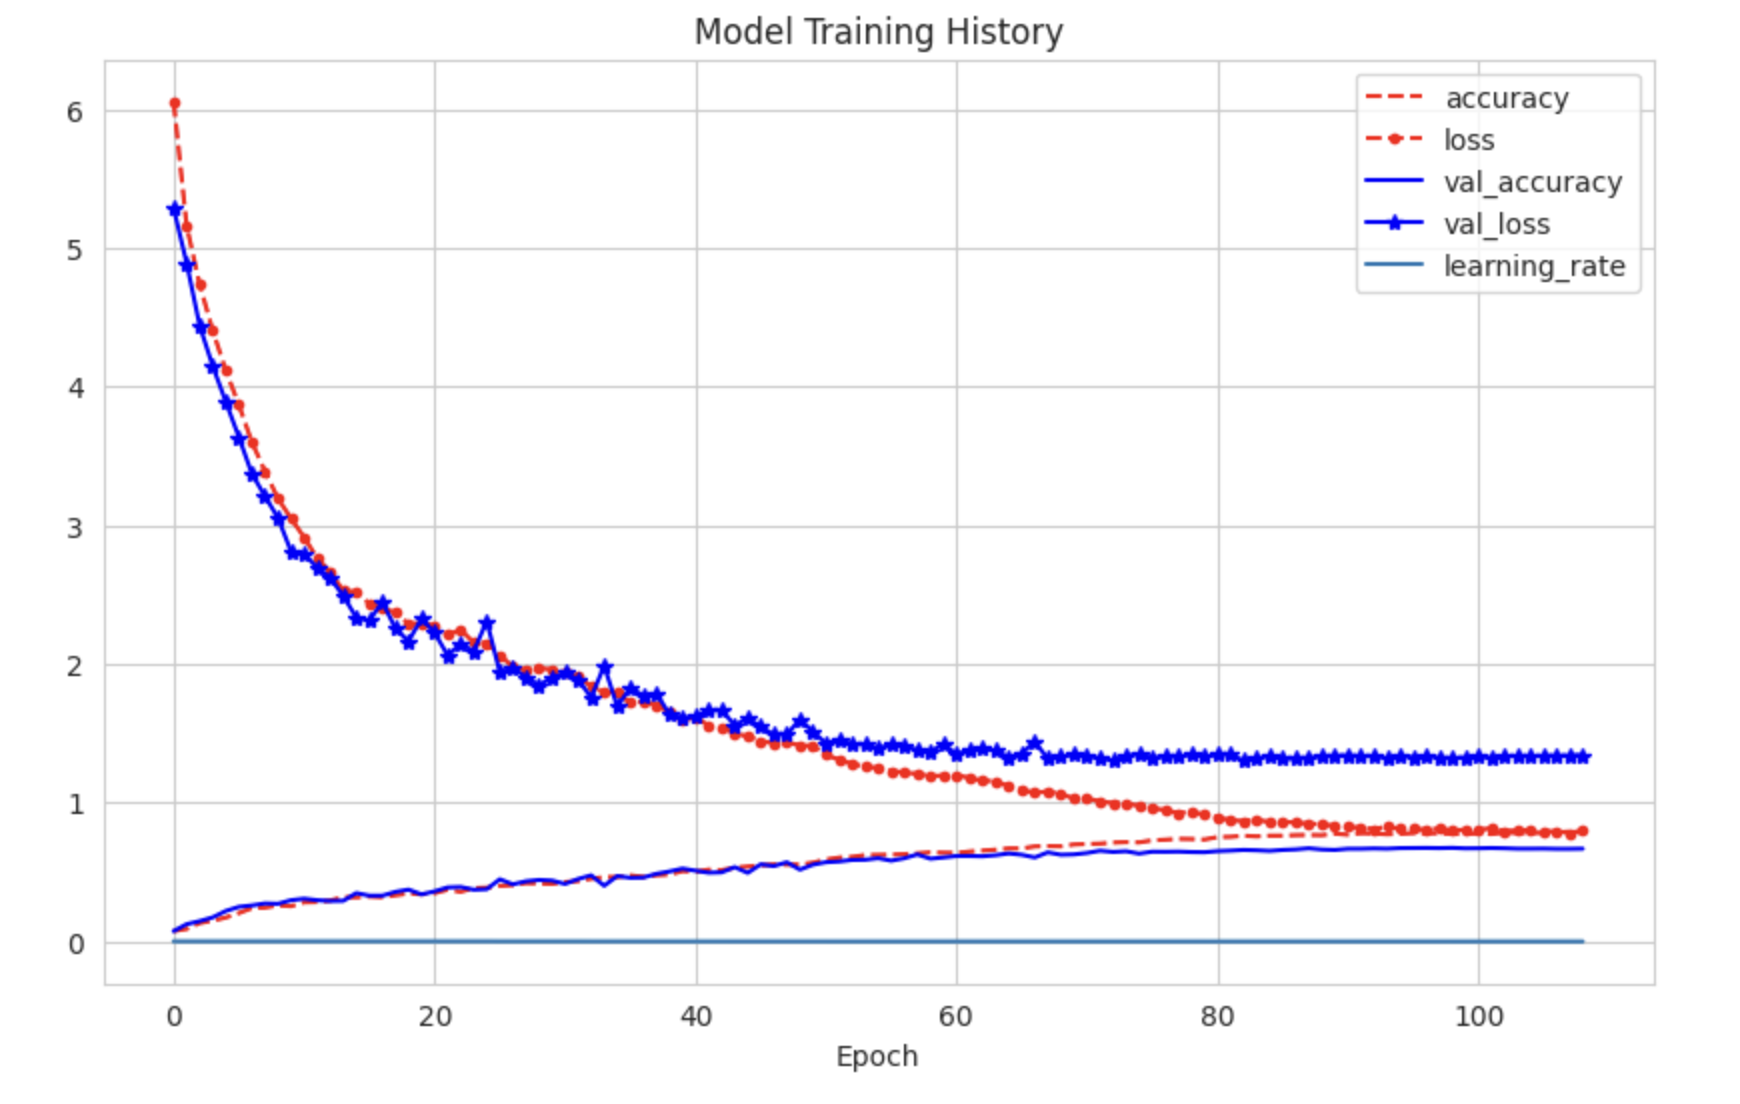

### Evaluating the Model



In [34]:
# generate predictions
val_probabilities = model_ALL.predict(val_padded_ALL)
y_pred_val_ALL = np.argmax(val_probabilities, axis=1)
print("First 10 Validation Predictions:")
print(y_pred_val_ALL[:10])
print("\nFirst 10 True Validation Labels:")
print(y_val_encoded_ALL[:10])

# generate classification report for IMU-only features
gesture_names_int = label_encoder.classes_
gesture_names_str = [str(name) for name in gesture_names_int]
report = classification_report(y_val_encoded_ALL, y_pred_val_ALL, target_names=gesture_names_str)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
First 10 Validation Predictions:
[ 6  5  0  7  7 10 11  0  7 16]

First 10 True Validation Labels:
[ 6  5  0  7  9  9 13  0  3  1]
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.78      0.81      0.79       149
                        Cheek - pinch skin       0.59      0.57      0.58       130
                     Drink from bottle/cup       0.92      0.88      0.90        26
                       Eyebrow - pull hair       0.43      0.35      0.39       122
                       Eyelash - pull hair       0.47      0.52      0.49       120
Feel around in tray and pull out an object       1.00      0.88      0.94        34
                  Forehead - pull hairline       0.65      0.57      0.61       129
                        Forehead - scratch       0.63      0.77      0.69       121
                            Glasses on/off       1.00      0.88      0.9

**A Quick Breakdown of the Evaluation Metrics:**

- *Precision:* This is the ratio of the true positives to the true positives + the false positives. In other words, it is the likelihood that the prediction matches the true gesture when the prediction is made.

- *Recall:* This is the ratio of the true positives to the true positives + the false negatives. This is the percentage of gestures in the dataset that the model was able to accurately predict.

- *F1-score:* This is a well-balanced metric that takes both precision and recall into account. It is widely used because it is difficult to BS through.

- *Support:* This is simply the number of times a gesture appears in the dataset.

Even with a decent overall weighted average, some of the model's issues can be identified on closer inspection. For instance, take a look at "Write name on leg". This gesture got a recall of 1.0 (meaning every instance of the gesture was predicted correctly), but also a precision of 0.3, meaning that in the process, it also incorrectly guessed lots other sequences to be "Write name on leg".

Now, take a look at "Pinch knee/leg skin". This gesture has the opposite problem, it has a precision of 1.0 but a recall of 0.03. With a count of 34, this means that it only guessed 1 gesture to be "Pinch knee/leg skin". That one prediction was correct, but every other sequence of "Pinch knee/leg skin" was predicted to be something else! Gee I wonder which gesture that would be... 🤔

Much like a human person, the model gets confused. I'm *sure* the IMU data for "Write name on leg" and "Pinch knee/leg skin" look very similar and would be tough for most people to distinguish.

### Performance curves for Other Configurations

Here are some performance curves I got while training various configurations of this model.

***Second Iteration (only IMU data):***

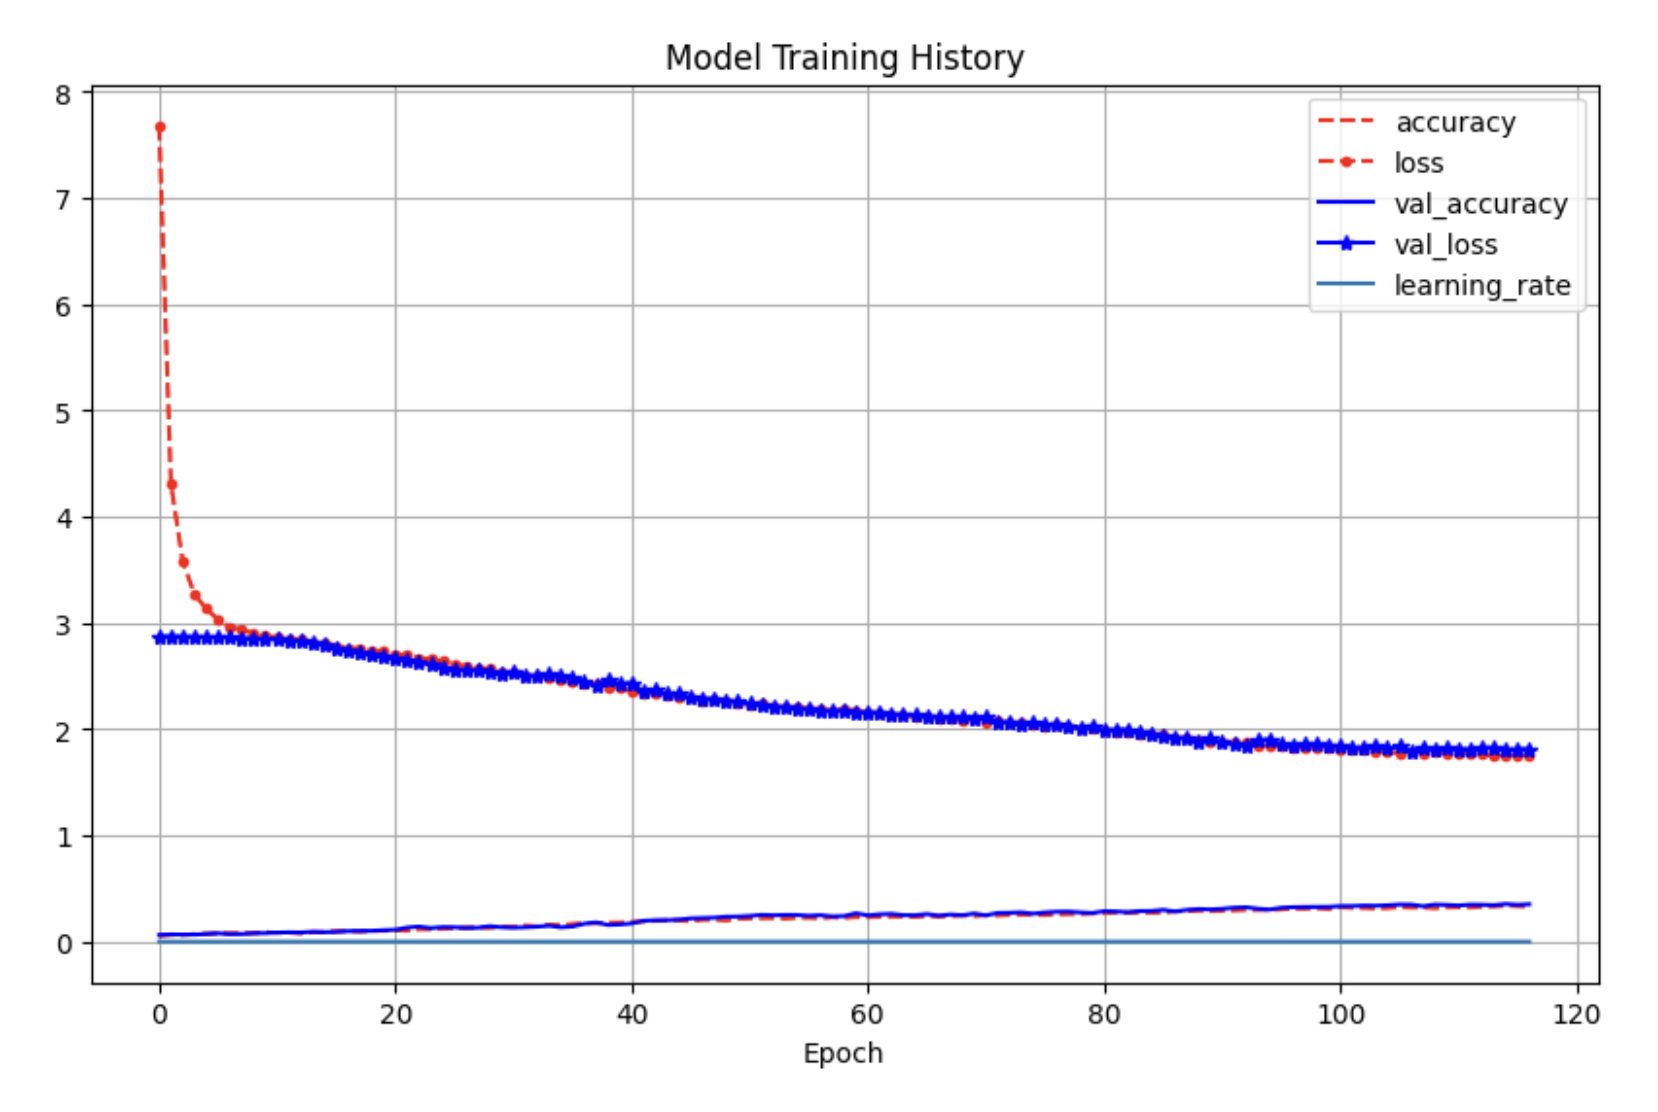

***Third Iteration (only IMU data):***

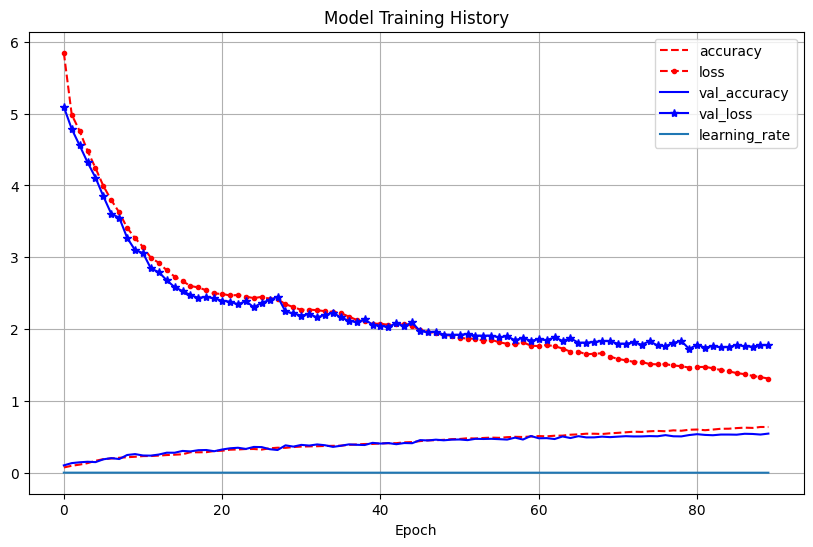

***Early Stopping on Val Accuracy:***

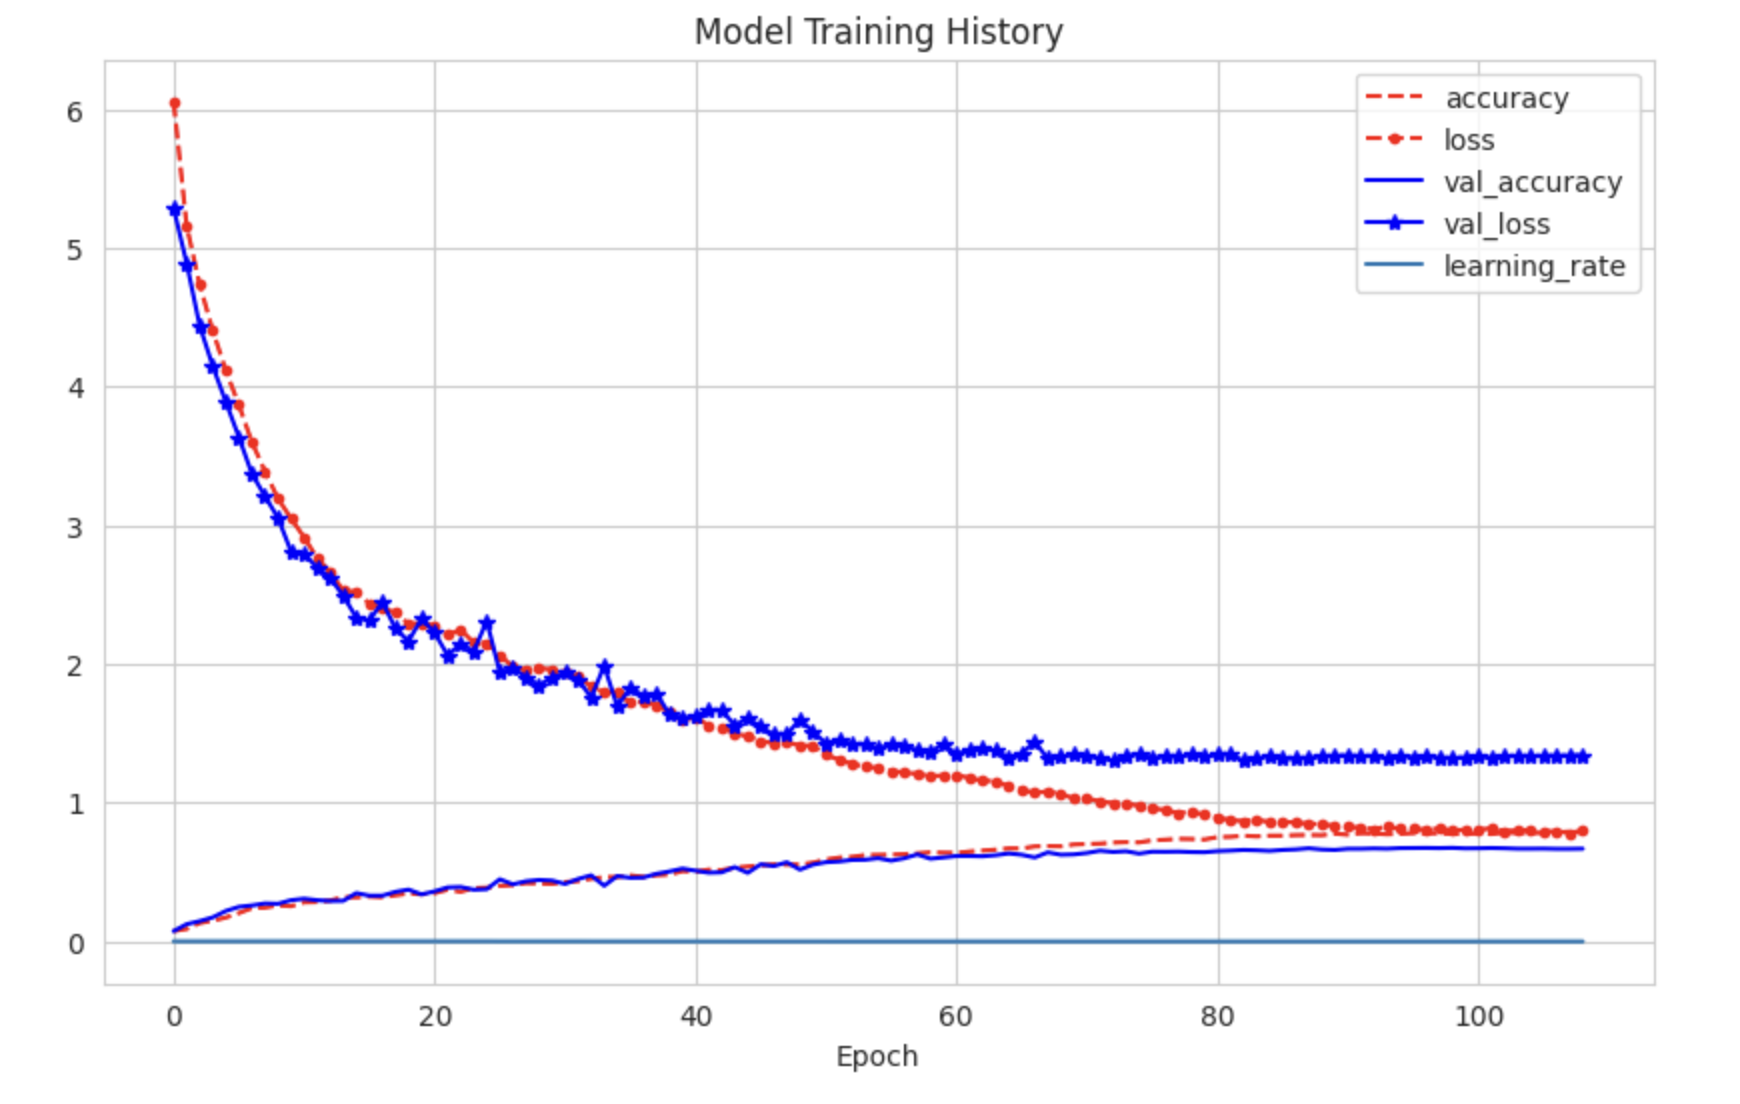
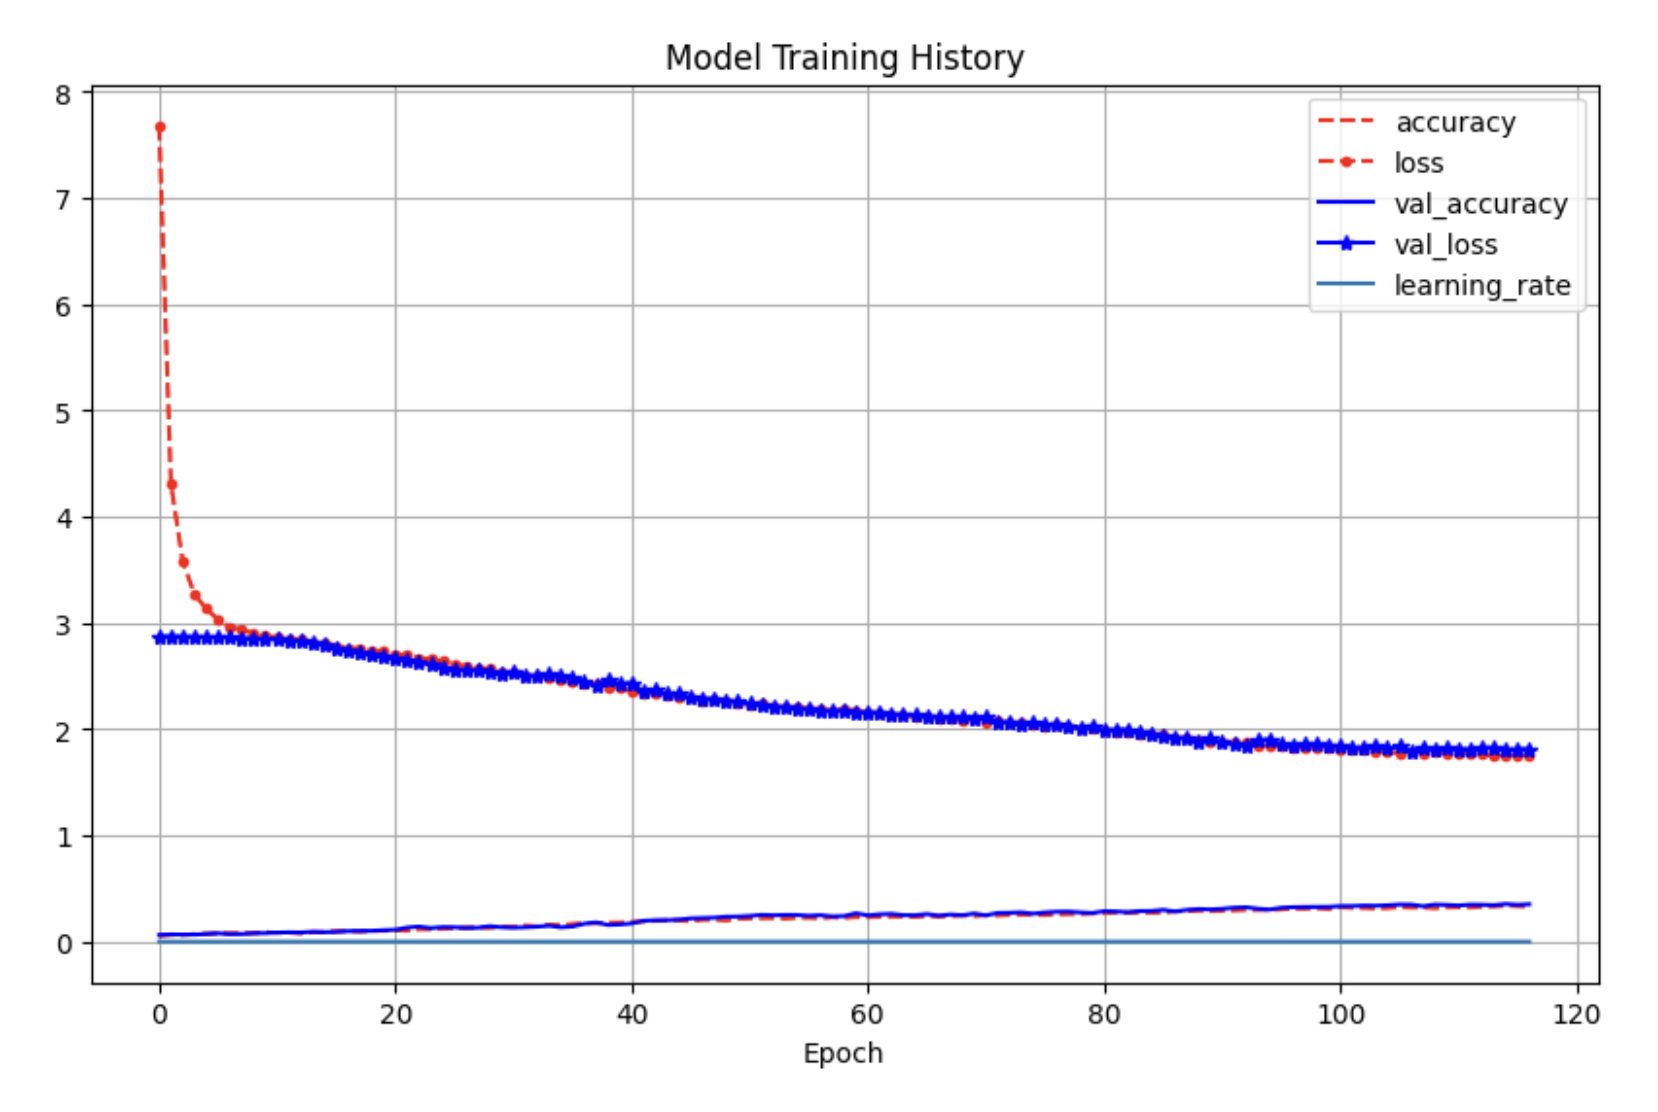

### Submission:

In [35]:
LABELS = [
    'Above ear - pull hair',
    'Cheek - pinch skin',
    'Drink from bottle/cup',
    'Eyebrow - pull hair',
    'Eyelash - pull hair',
    'Feel around in tray and pull out an object',
    'Forehead - pull hairline',
    'Forehead - scratch',
    'Glasses on/off',
    'Neck - pinch skin',
    'Neck - scratch',
    'Pinch knee/leg skin',
    'Pull air toward your face',
    'Scratch knee/leg skin',
    'Text on phone',
    'Wave hello',
    'Write name in air',
    'Write name on leg'
]

In [36]:
import polars as pl

def process_single_sequence(df_seq: pd.DataFrame) -> np.ndarray:
    if isinstance(df_seq, pl.DataFrame):
        df_seq = df_seq.to_pandas()
    
    df_seq = df_seq.copy()

    # drop duplicate rows
    df_seq.drop_duplicates(inplace=True)

    # replace -1 and 0 with NaN in TOF columns
    tof_cols = [c for c in df_seq.columns if c.startswith('tof_')]
    if tof_cols:
        df_seq[tof_cols] = df_seq[tof_cols].replace([-1, 0], np.nan)

    # impute missing rot values with 0
    rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
    existing_rots = [c for c in rots if c in df_seq.columns]
    if existing_rots:
        df_seq[existing_rots] = df_seq[existing_rots].fillna(0)

    # fill missing temperature data with average by column (Constant 0 strategy)
    thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
    existing_thms = [c for c in thms if c in df_seq.columns]
    if existing_thms:
        df_seq[existing_thms] = df_seq[existing_thms].fillna(0)

    # fill all NaNs in time-of-flight (ToF) columns with 400
    if tof_cols:
        df_seq[tof_cols] = df_seq[tof_cols].fillna(400)

    # linear interpolation for missing acceleration data
    acc_cols = ["acc_x", "acc_y", "acc_z"]
    if all(c in df_seq.columns for c in acc_cols):
        df_seq[acc_cols] = df_seq[acc_cols].interpolate(method='linear', limit_direction='both')

    # drop unnecessary columns
    columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']
    df_seq = df_seq.drop(columns=[col for col in columns_to_drop if col in df_seq.columns])

    # calculate new features and concatenate
    new_features_df = calculate_sequence_features(df_seq)
    df_processed = pd.concat([df_seq, new_features_df], axis=1)
    
    # reorder columns
    NEW_IMU_FEATURES = [
        'lin_acc_x', 'lin_acc_y', 'lin_acc_z',
        'acc_mag', 'lin_acc_mag', 
        'acc_mag_jerk', 'lin_acc_mag_jerk', 
        'rot_angle', 'angular_distance', 'rot_angle_vel', 
        'angular_vel_x', 'angular_vel_y', 'angular_vel_z'
    ]
    
    id_cols = ['sequence_id']
    if 'gesture' in df_processed.columns:
        id_cols.append('gesture')
    
    original_cols = [
        col for col in df_processed.columns 
        if col not in id_cols and col not in NEW_IMU_FEATURES
    ]
    
    final_order = id_cols + NEW_IMU_FEATURES + original_cols
    final_order = [c for c in final_order if c in df_processed.columns]
    df_processed = df_processed[final_order]

    # scale features
    cols_to_exclude = ['sequence_id', 'gesture']
    cols_to_scale = [c for c in df_processed.columns if c not in cols_to_exclude]
    df_processed[cols_to_scale] = scaler.transform(df_processed[cols_to_scale])

    # pad sequence
    if 'sequence_id' in df_processed.columns:
        df_processed = df_processed.drop(columns=['sequence_id'])
    if 'gesture' in df_processed.columns:
        df_processed = df_processed.drop(columns=['gesture'])
    padded_sequences = pad_sequences([df_processed.values], padding='post', dtype='float32', maxlen=700)

    return padded_sequences

In [37]:
# define prediction for hidden test set
def predict(sequence: pd.DataFrame, demographics: pd.DataFrame) -> str:
    input_data = process_single_sequence(sequence)
    prediction_probs = model_ALL.predict(input_data, verbose=0) 
    predicted_index = np.argmax(prediction_probs, axis=1)[0]
    predicted_label = LABELS[predicted_index]
    return predicted_label

In [38]:
import kaggle_evaluation.cmi_inference_server

inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )